# Antibody Developability Challenge - Data Visualization

Gingko DataPoints - Fall 2025

**Authors**: Shyam Chandra, Valentin Badea

Contact: valentin.badea@hms.harvard.edu, shyam.chandra@hms.harvard.edu

# Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (12, 8)

# Data Loading

In [22]:
# Load the MOE features and targets
path_to_data = "../data/features/processed_features/GDPa1/MOE_properties.csv"
path_to_target = "../data/GDPa1_v1.2_20250814.csv"

df_master = pd.read_csv(path_to_data, index_col=0)
df_target = pd.read_csv(path_to_target, index_col=0)

In [23]:
out_features = ['antibody_name', 'mseq']
moe_features = [col for col in df_master.columns if col not in out_features]
print(f"Total MOE features: {len(moe_features)}")
df_master_filtered = df_master[moe_features]

Total MOE features: 46


In [28]:
target_features = ['HIC', 'Titer', "PR_CHO", 'AC-SINS_pH7.4', 'Tm2']
df_target_properties = df_target[target_features]

# Dimensionality reduction

## PCA

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [32]:
scaler = StandardScaler()
df_master_filtered_scaled = scaler.fit_transform(df_master_filtered)
pca = PCA(n_components=2)
df_master_filtered_pca = pca.fit_transform(df_master_filtered_scaled)

In [40]:
df_target_properties[target_features[0]]

antibody_id
GDPa1-001    2.590
GDPa1-002    2.545
GDPa1-003    2.705
GDPa1-004    2.565
GDPa1-005    2.495
             ...  
GDPa1-242    2.495
GDPa1-243    4.500
GDPa1-244    2.590
GDPa1-245    2.660
GDPa1-246    2.530
Name: HIC, Length: 246, dtype: float64

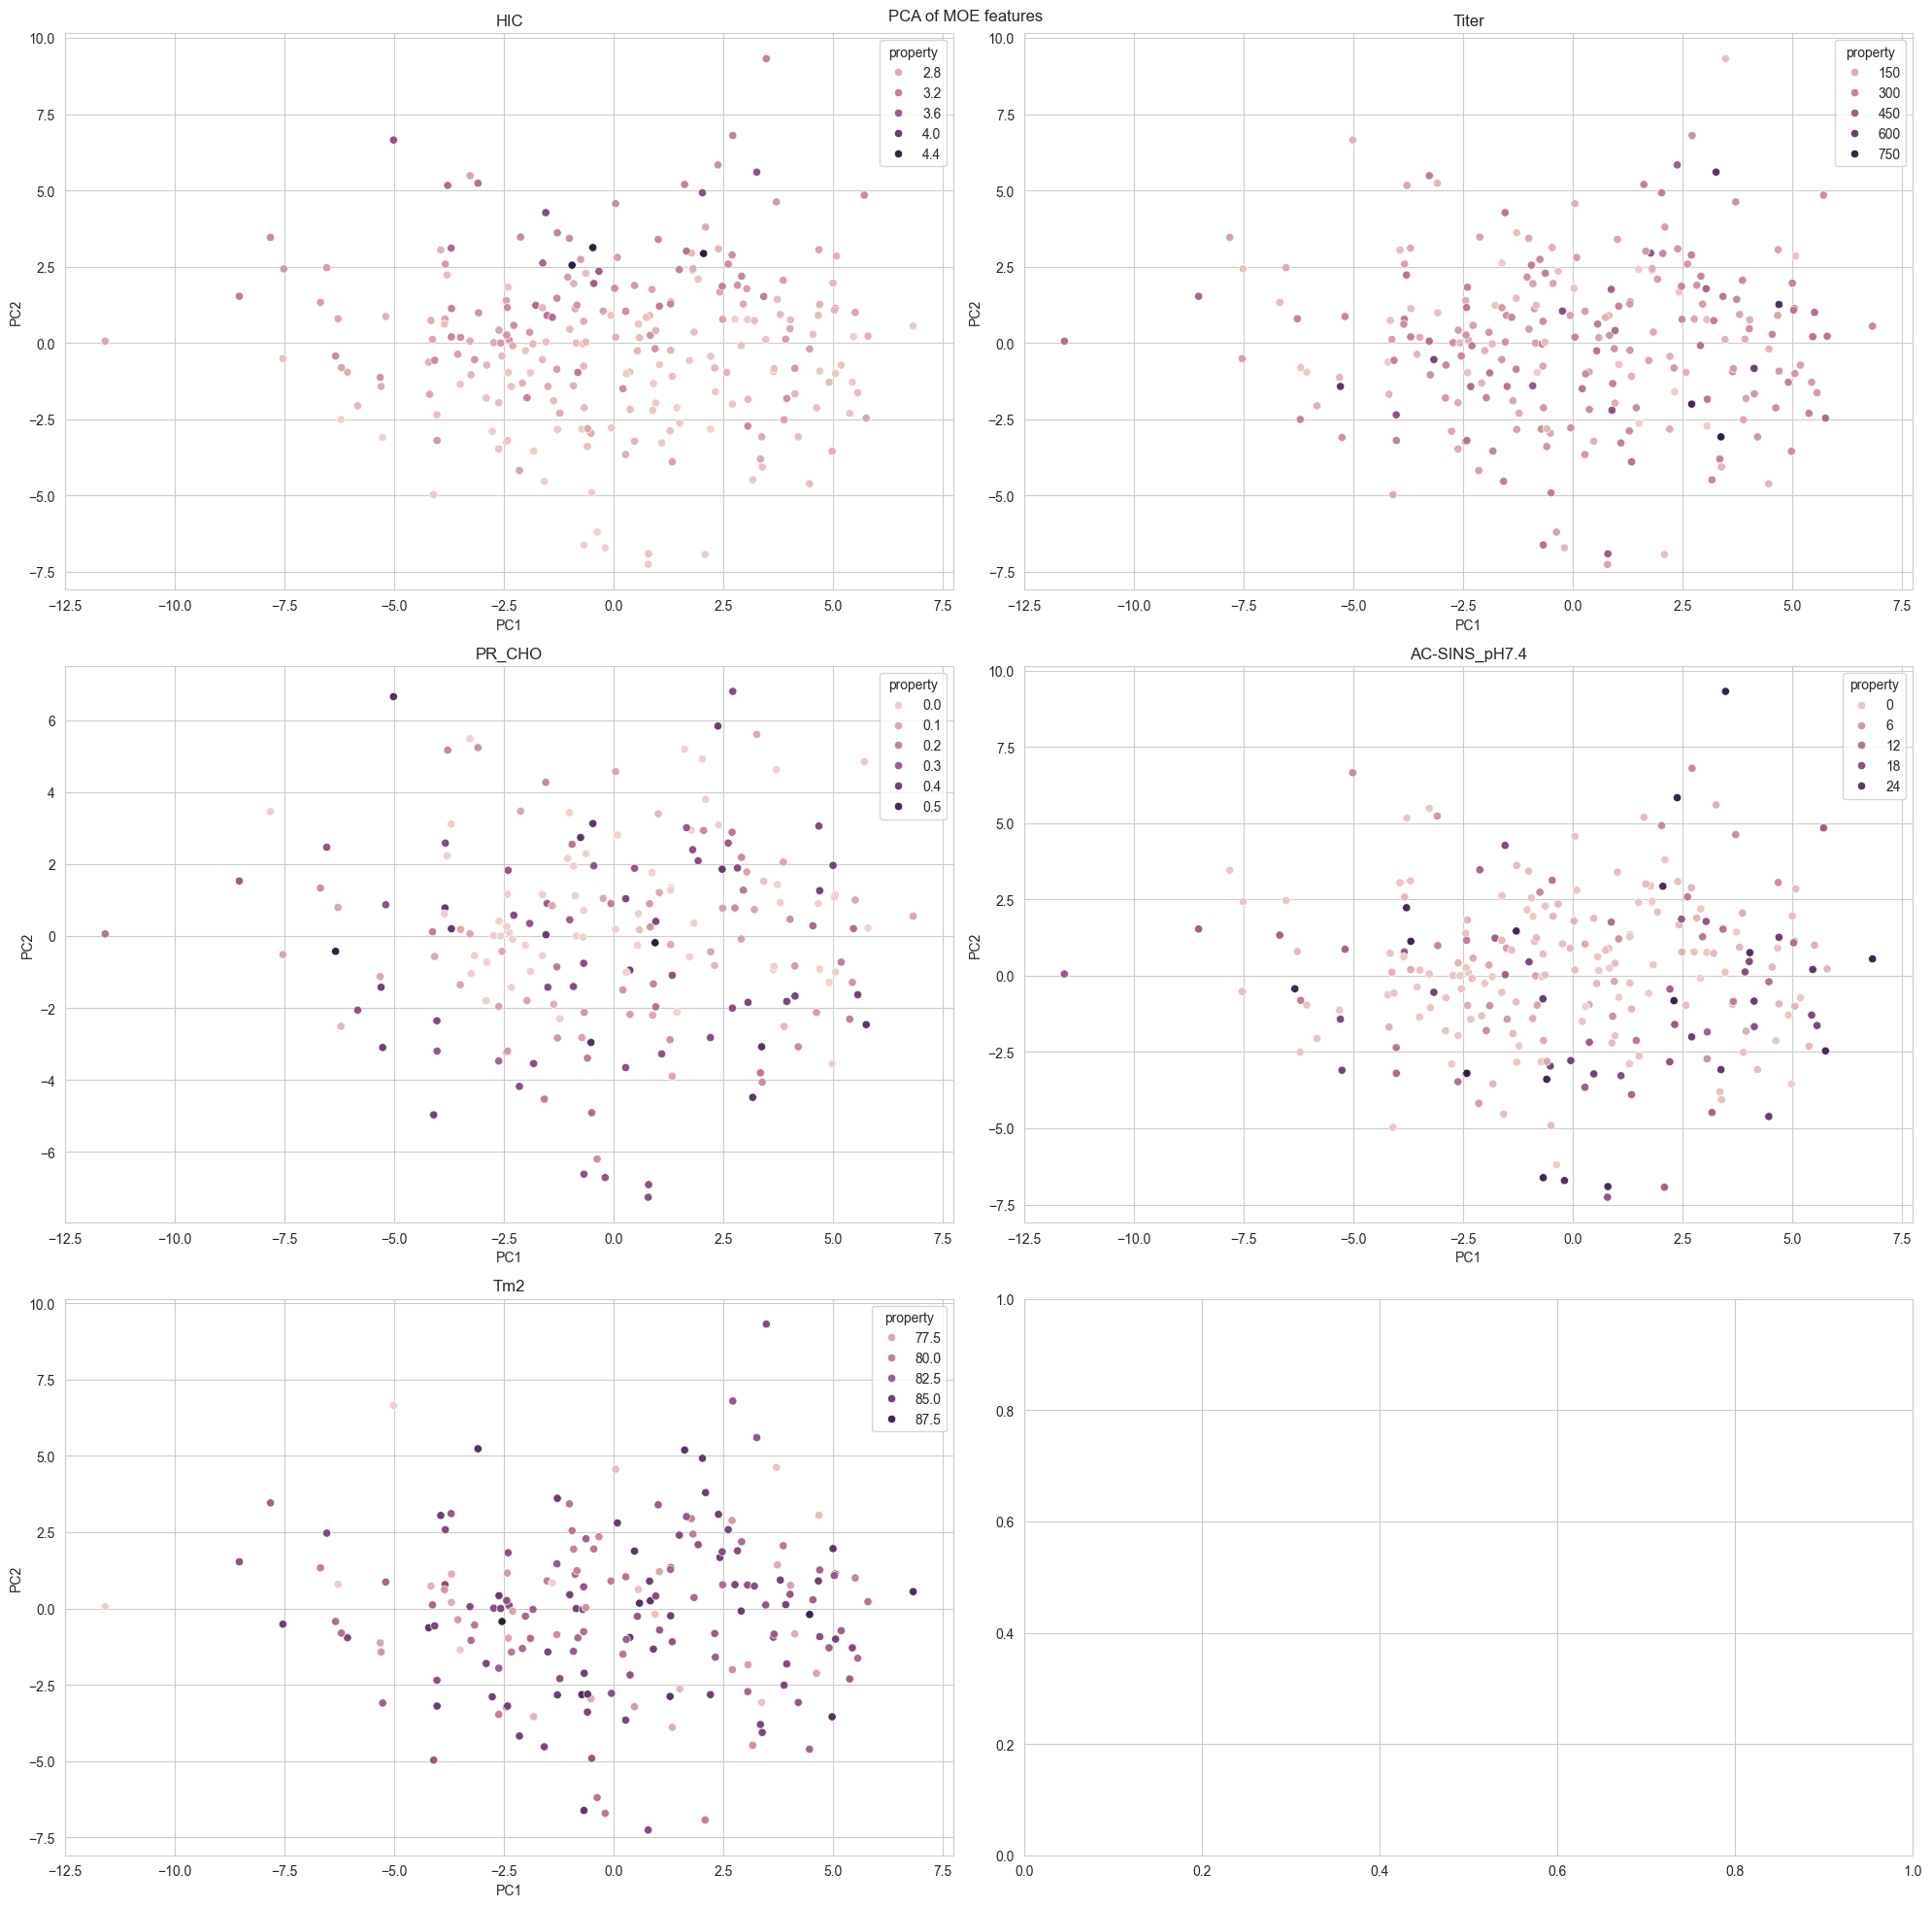

In [44]:
def plot_dim_red(df_master_filtered_pca, df_properties, ax, property = 'HIC'):
  df_master_filtered_pca_df = pd.DataFrame(df_master_filtered_pca, columns=['PC1', 'PC2'])
  df_master_filtered_pca_df["property"] = df_properties[property].values
  sns.scatterplot(data=df_master_filtered_pca_df, x='PC1', y='PC2', hue=df_master_filtered_pca_df["property"], ax=ax)
  return ax

fig, ax = plt.subplots(3,2, figsize=(20,20))
fig.suptitle('PCA of MOE features')
for i, property in enumerate(target_features):
  ax[i//2, i%2] = plot_dim_red(df_master_filtered_pca, df_target_properties, ax[i//2, i%2], property)
  ax[i//2, i%2].set_title(property)
  ax[i//2, i%2].set_xlabel('PC1')
  ax[i//2, i%2].set_ylabel('PC2')
plt.tight_layout()
plt.show()

## UMAP

In [46]:
from umap import UMAP

df_master_filtered_scaled = scaler.fit_transform(df_master_filtered)
umap = UMAP(n_components=2)
df_master_filtered_umap = umap.fit_transform(df_master_filtered_scaled)

c:\Users\badea\micromamba\envs\molml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


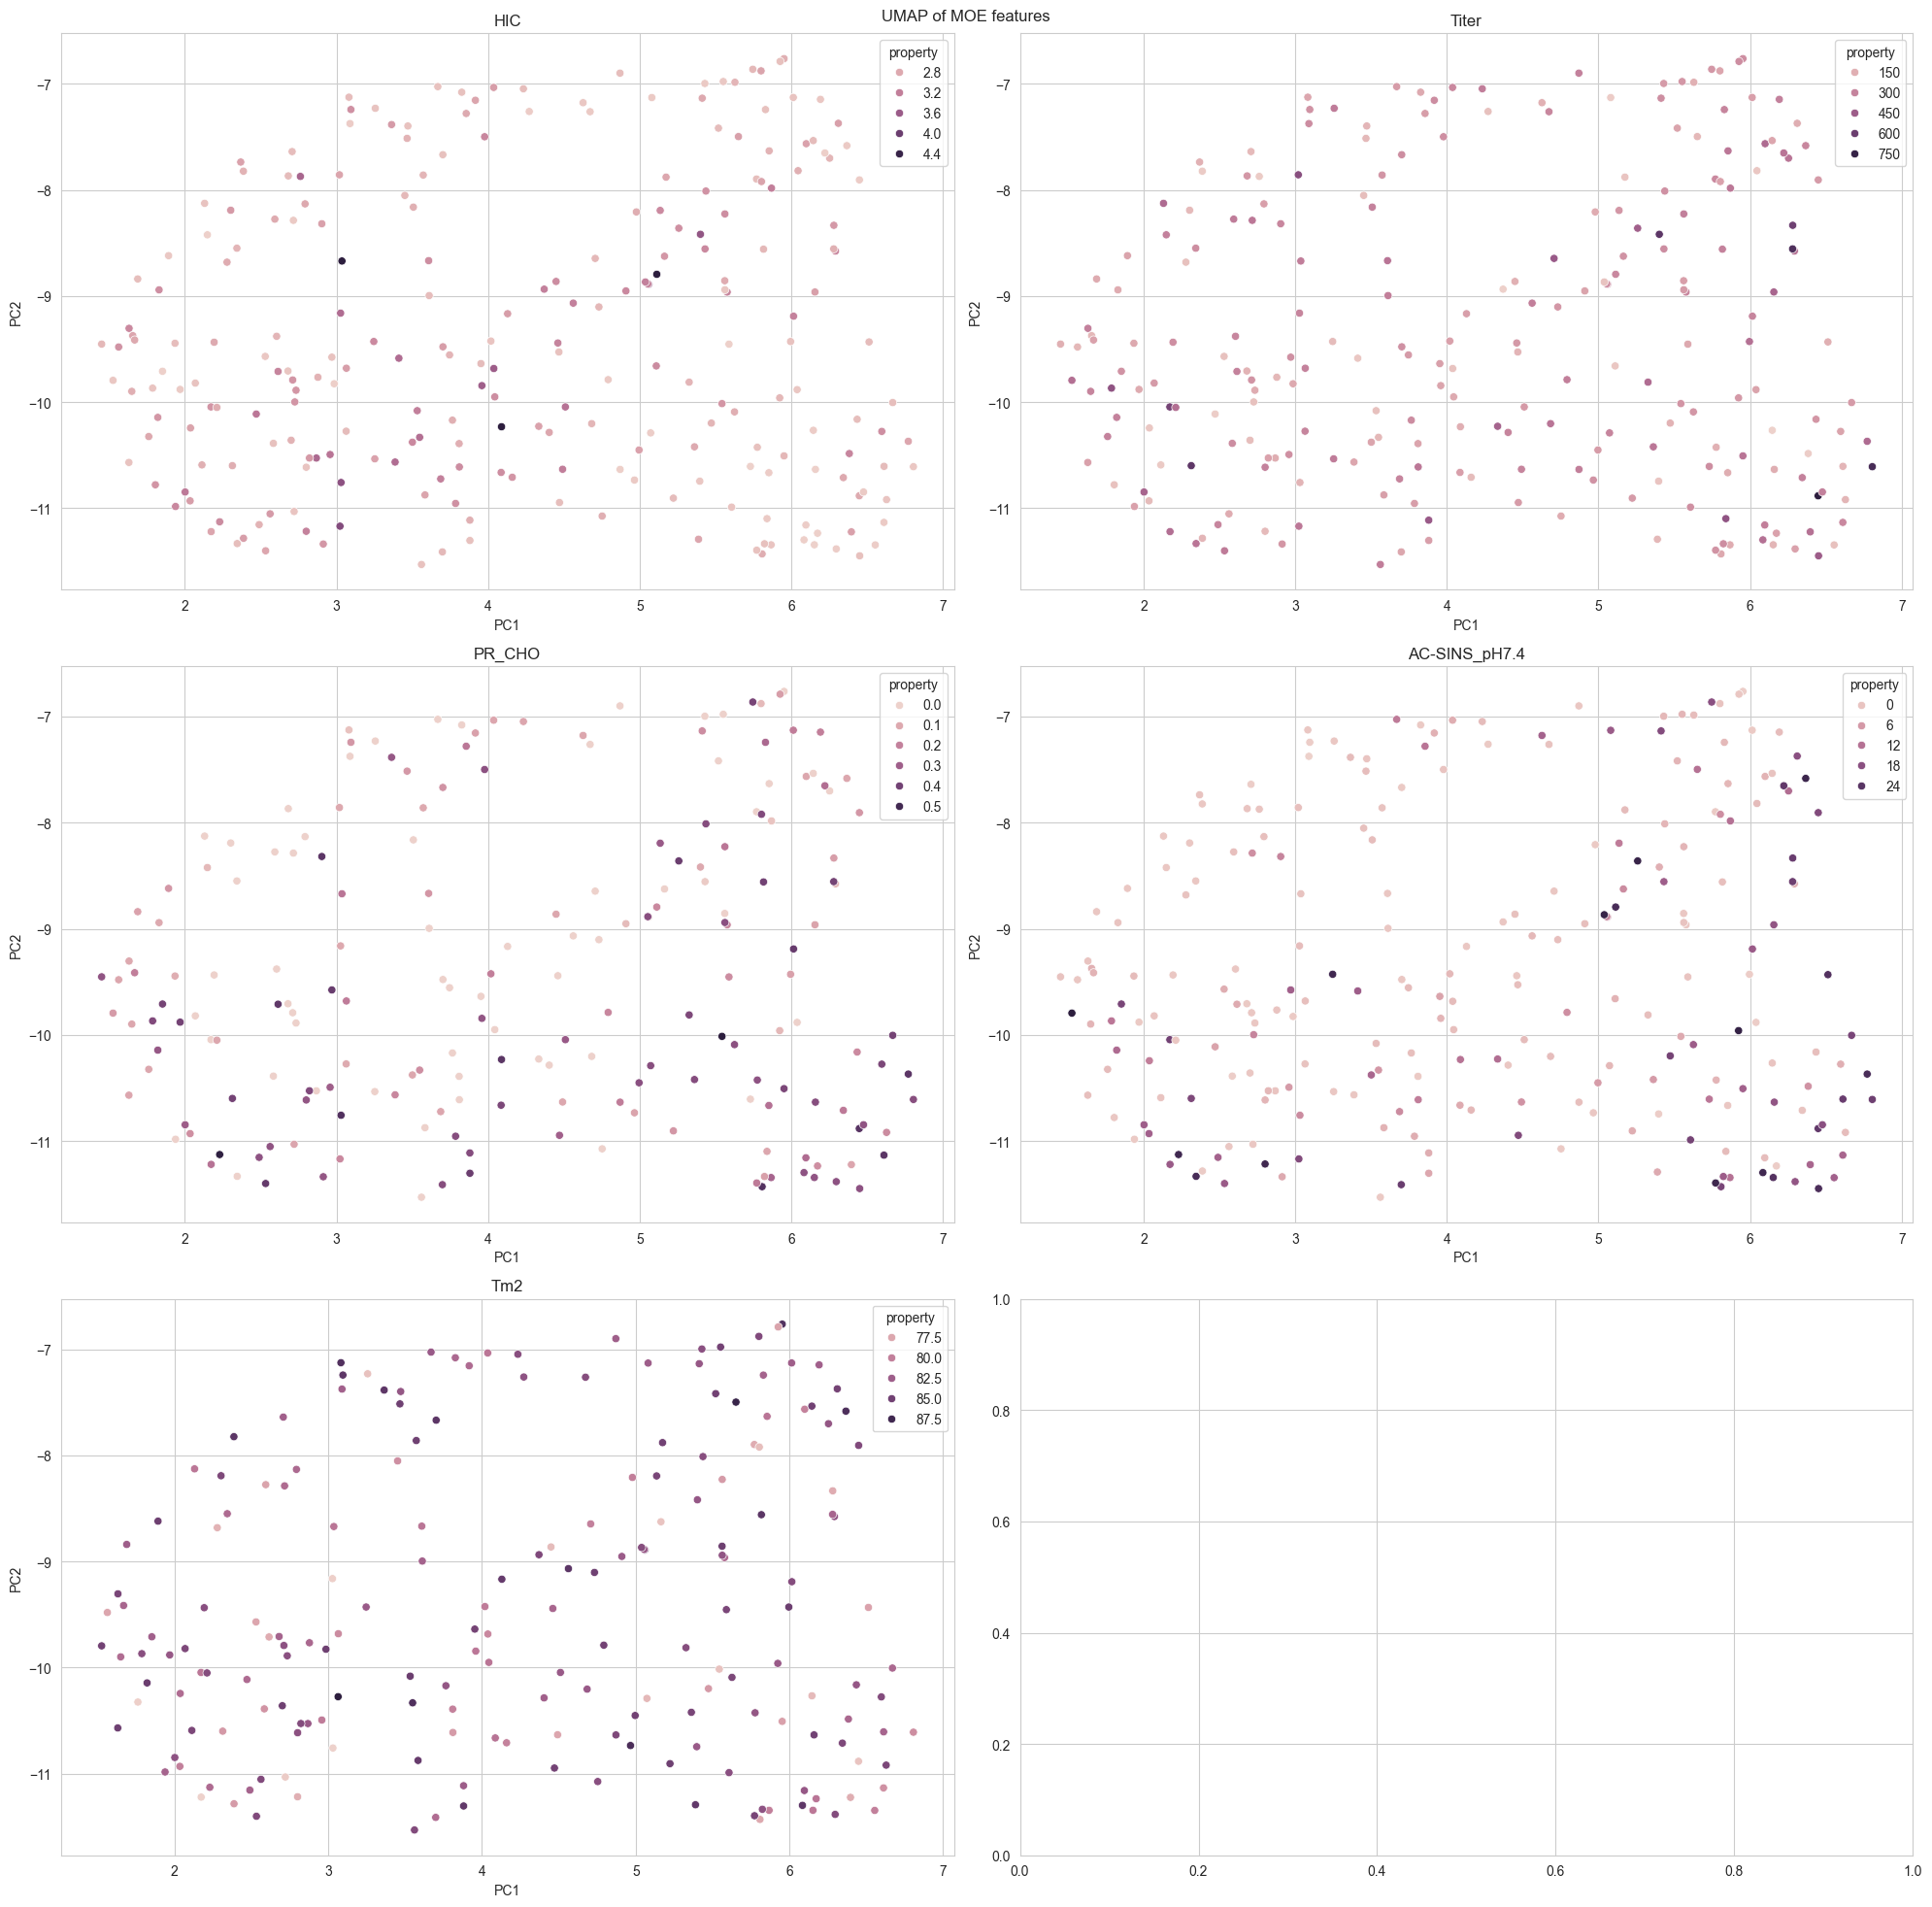

In [47]:
fig, ax = plt.subplots(3,2, figsize=(20,20))
fig.suptitle('UMAP of MOE features')
for i, property in enumerate(target_features):
  ax[i//2, i%2] = plot_dim_red(df_master_filtered_umap, df_target_properties, ax[i//2, i%2], property)
  ax[i//2, i%2].set_title(property)
  ax[i//2, i%2].set_xlabel('PC1')
  ax[i//2, i%2].set_ylabel('PC2')
plt.tight_layout()
plt.show()

# Correlation analysis

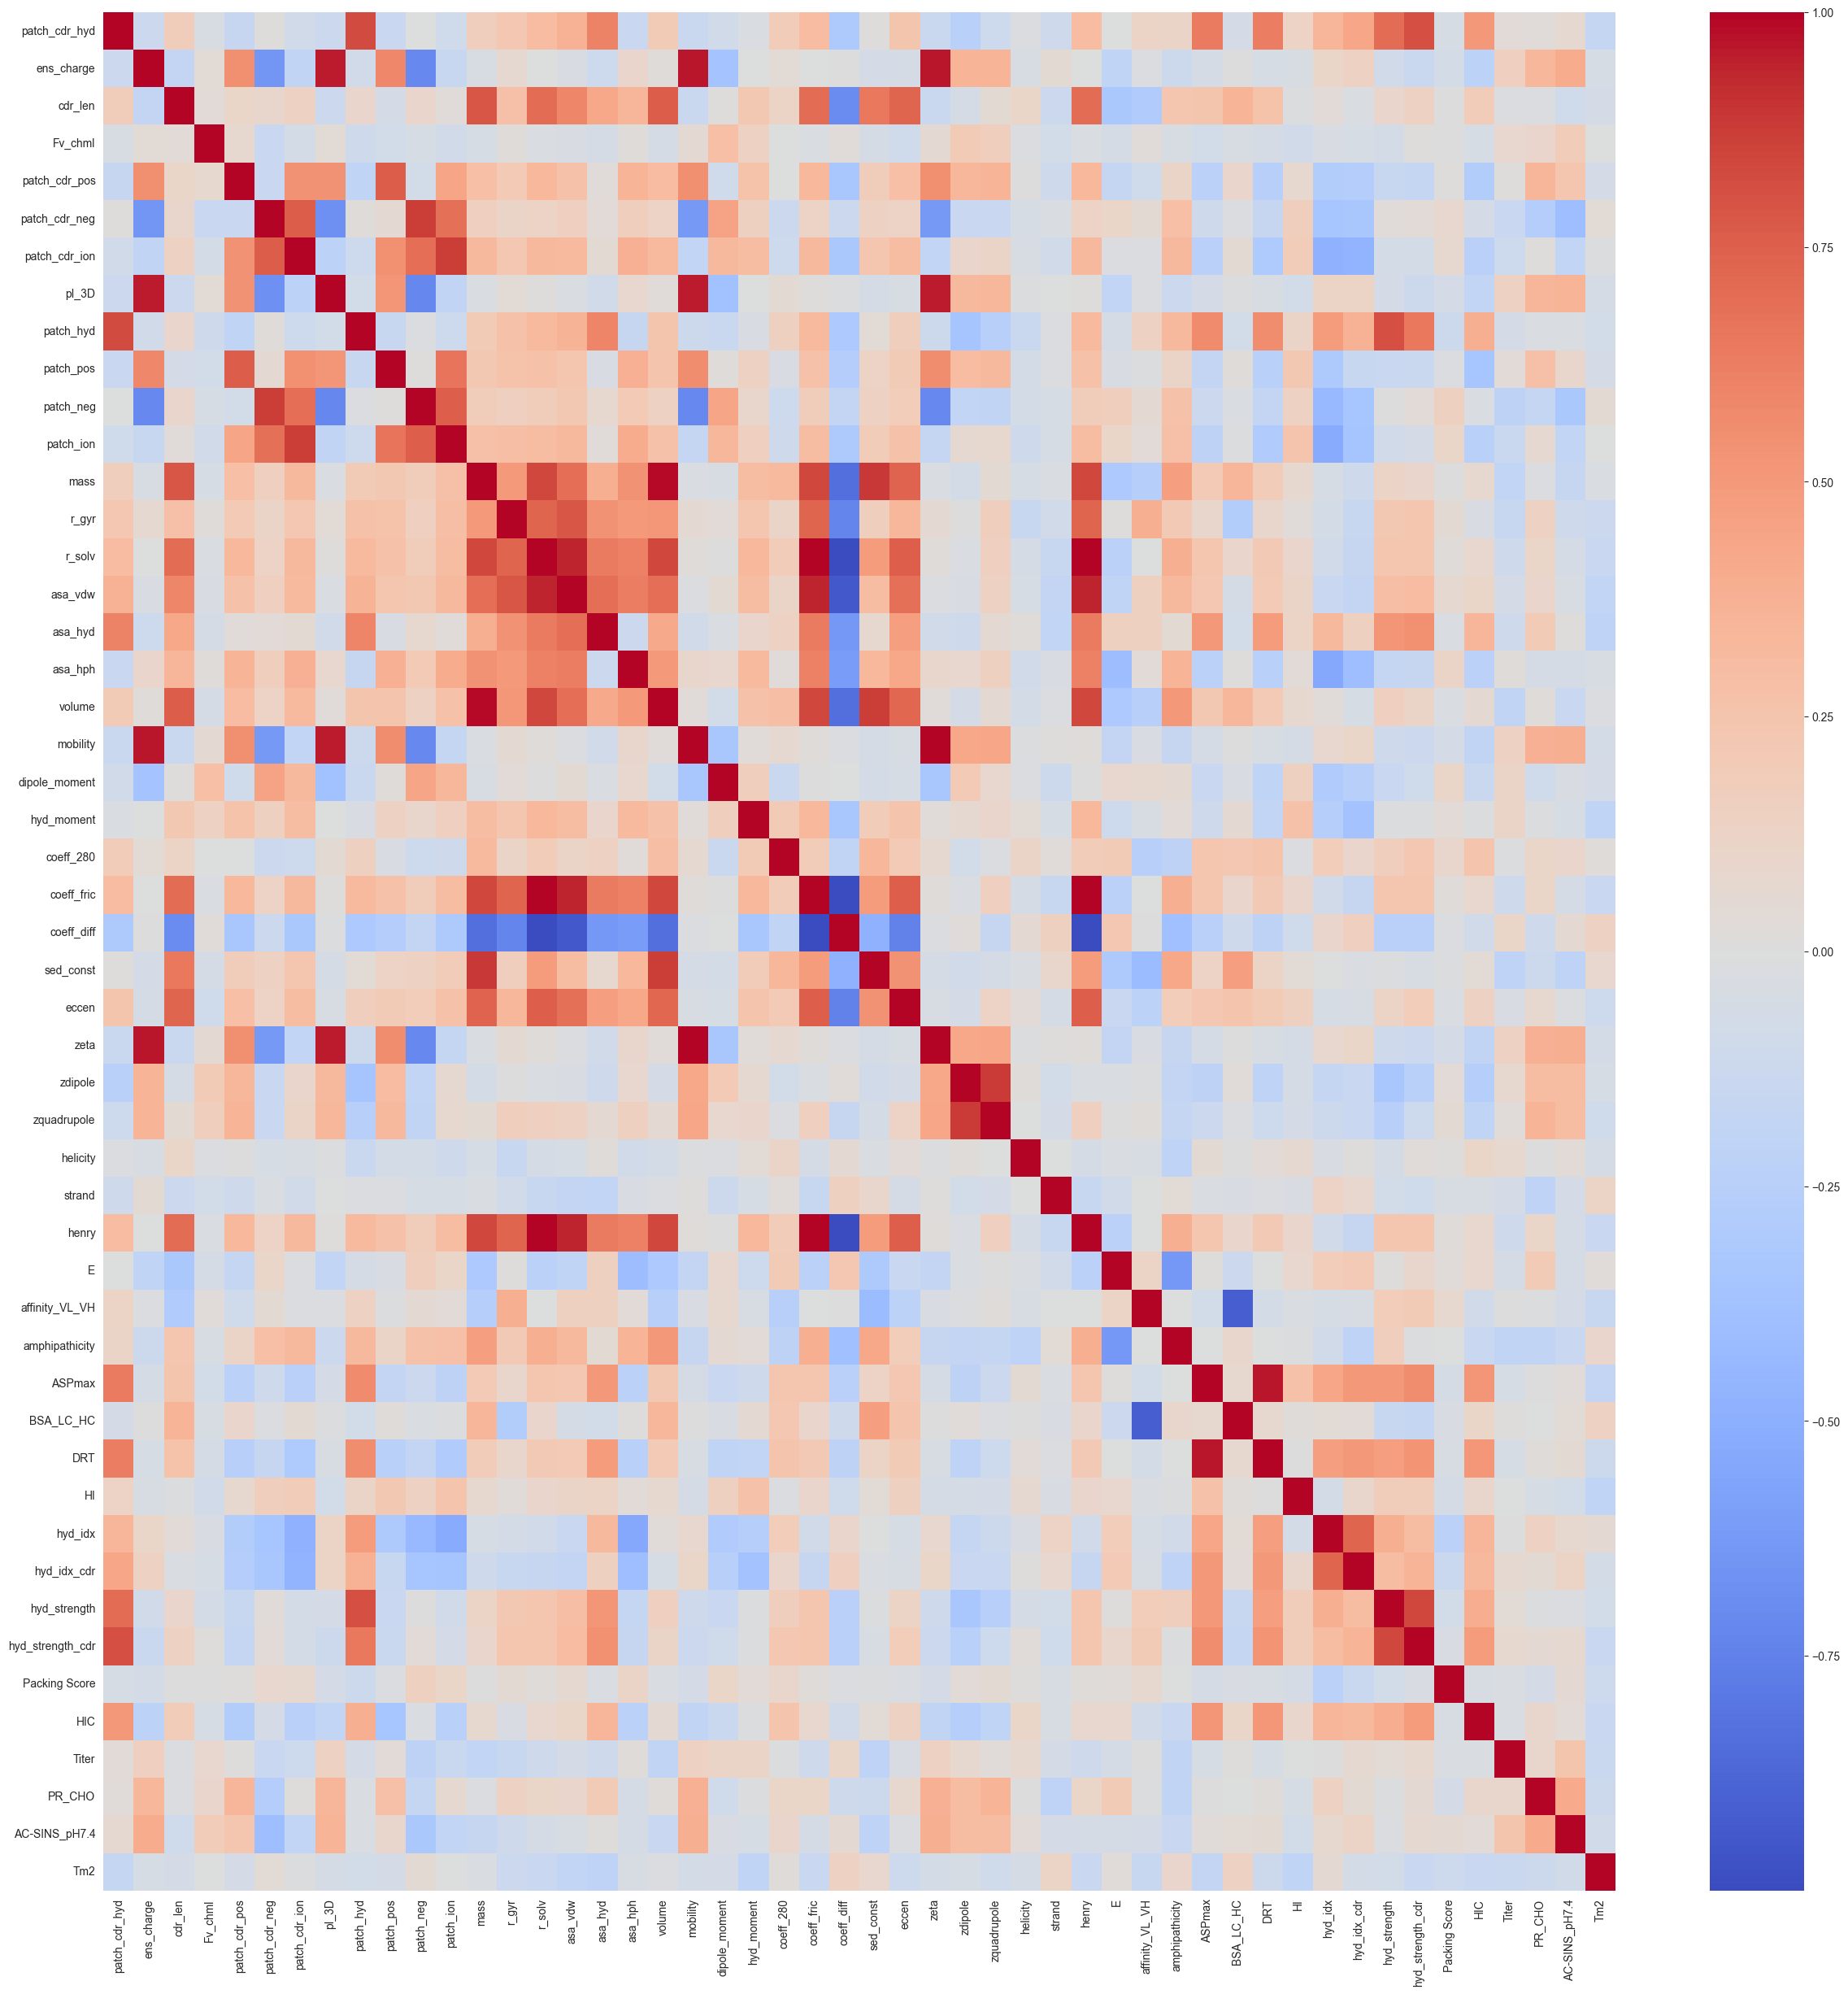

In [48]:
df_master_filtered_prop = pd.concat([df_master_filtered, df_target_properties], axis=1)
df_master_filtered_prop.drop(columns = ["debye"], inplace=True) #that column has near 0 std => correlation not defined
df_corr = df_master_filtered_prop.corr()

plt.figure(figsize=(30,30))
sns.heatmap(df_corr, annot=False, cmap='coolwarm')
plt.show()

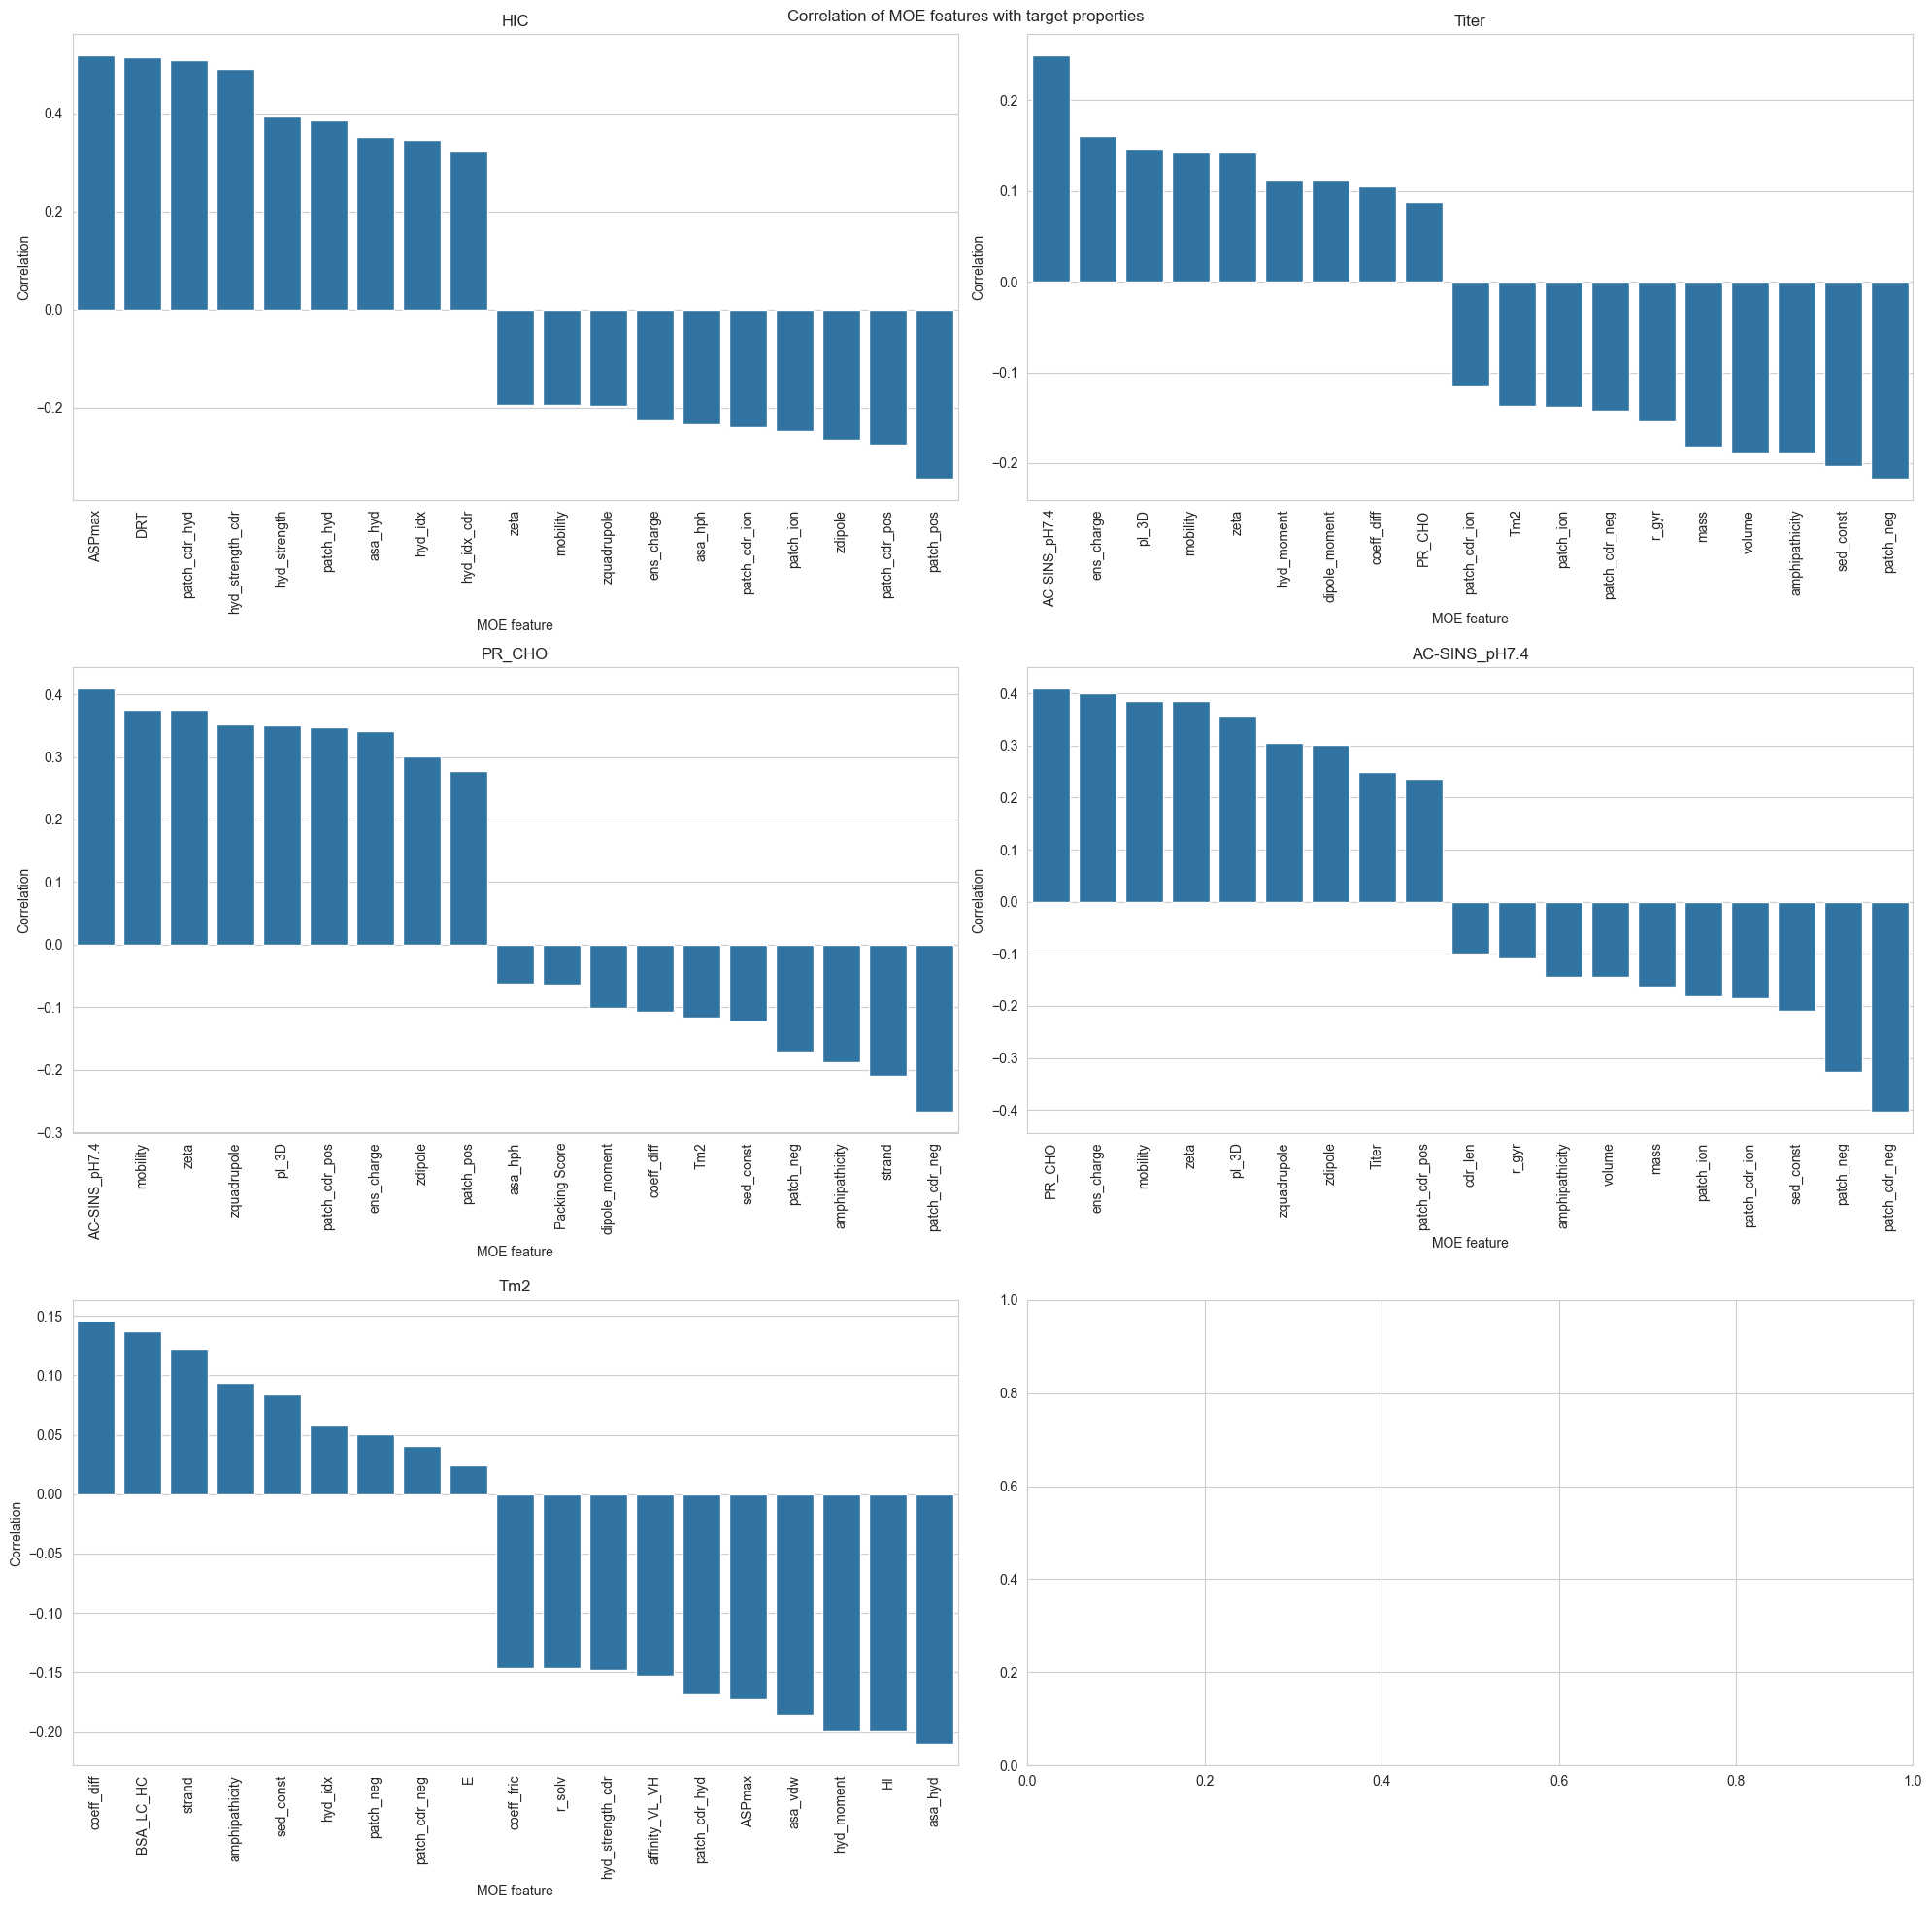

In [50]:
def plot_top_k_corr_to_target(df_corr, ax, target, k=10, mode = "plusminus"):
  df_corr_target = df_corr[target].sort_values(ascending=False)
  if mode == "plusminus":
    mid_k = int(k/2)
    df_corr_target = pd.concat([df_corr_target[1:mid_k], df_corr_target[-mid_k:]], axis=0)
  elif mode == "plus":
    df_corr_target = df_corr_target[1:k+1]
  else:
    df_corr_target = df_corr_target[-k:]
  sns.barplot(x=df_corr_target.index, y=df_corr_target.values, ax=ax)
  return ax

fig, axs = plt.subplots(3,2, figsize=(20,20))
fig.suptitle('Correlation of MOE features with target properties')
for i, property in enumerate(target_features):
  ax = axs[i//2, i%2]
  ax = plot_top_k_corr_to_target(df_corr, ax, property, k = 20)
  ax.set_title(property)
  ax.set_xlabel('MOE feature')
  ax.set_ylabel('Correlation')
  # center and rorate ticks
  ax.tick_params(axis='x', rotation=90, bottom=False)
  # ax.set_ylim(-1,1)
plt.tight_layout()
plt.show()

# Linear Feature Selection

**Inspiration**: Stabl (see J. Hédou et al, 2024, Nature Biotechnology).

**Idea**: Single cell proteomics has for long had to deal with low sample datasets in high-dimensional predictive configurations (notably where $n << p$). Although, we're not fully concerned with this dimensionality issue here ($n > p$), we believe that this algorithm would provide a powerful performance-agnostic selection method to identify the features that are most stringent for target prediction. 

**Steps**: Train fold with $n$ observations/$p$ parameters. For evey hyperparameter $\lambda \in [\lambda_{min}, \lambda_{max}]$, we train set of LASSO estimators. We fix $\lambda$ in the interval:

> 1. Generate $n_{bootstraps}$ bootstraps of the train fold
> 2. Then generate $p$ artificial (uninformative) features from actual features permutated
> 3. On every bootstrap with $2p$ features, run $LASSO(\lambda)$.
> 4. Report every selected features frequency in each boostrap: $(f_i^{(\lambda)})_i$
> 5. Repear steps 1-4 for every $\lambda \in [\lambda_{min}, \lambda_{max}]$.

The previous algorithm gives a series of hyperparameters-frequency pairs $(\lambda_i, f_{j}^{(i)})$. For every frequency threshold $t$ one could apply stability selection and decide to keep all the "real" features that have a maximum selection frequency overall hyperparameters and folds $\geq t$.  At this point, let's remember that Stabl was engineered to rely on artifical uninformative features to allow for data-driven feature selection.

More specifically, let's choose a given threshold $t \in [0,1]$. Applying this selection rule, gives us a set of selected features $O_t$, which contains a possibly empty set $A_t$ of artificial features. We compute:
$$FDP_{+}(t) = \frac{1+\#A_t}{ \max(\#O_t,1)}$$

The Stabl paper gives nice theoretical guarantees that this quantity can serve as an estimator of the false discovery rate in this set of selected features. Moreover, we choose $t_{opt} = \arg \min_{t \in [0,1]} FDP_{+}(t)$ and derive our final selection method:

$$\text{Choose feature across all real and artificial features only if their selection frequency is larger than }t_{opt}$$

In [51]:
# import LASSO regression
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
# low variance threshold
from sklearn.feature_selection import VarianceThreshold

In [52]:
def generate_bootstrap_from_dataset(df_main_dataset, n_bootstraps):
  df_bootstrapped = df_main_dataset.sample(frac=1, replace=True).reset_index(drop=True)
  for i in range(n_bootstraps-1):
    bootstrap_i = df_main_dataset.sample(frac=1, replace=True).reset_index(drop=True)
    df_bootstrapped = pd.concat([df_bootstrapped, bootstrap_i])
  return df_bootstrapped

def generate_artificial_permuted_features(df_bootstrapped,  target_prop = "HIC", fraction = 1.):
  #sampling on columns not row
  df_old = df_bootstrapped.drop(columns = [target_prop])
  d_old_sampled = df_old.sample(frac=fraction, axis=1)
  # shuffle rows
  df_artificial_shuffled = d_old_sampled.sample(frac=1, axis=0).reset_index(drop=True)
  df_artificial_shuffled.columns = [col + "_artificial" for col in df_artificial_shuffled.columns]
  df_artificial_suffled = pd.concat([df_bootstrapped.reset_index(drop=True), df_artificial_shuffled], axis=1)
  return df_artificial_suffled

def fit_lasso_on_one_bootstrap(df_artificial_one, df_target_one, alpha_param, max_iter = 1000):
    selected_features = []
    X_train = df_artificial_one.values
    y_train = df_target_one.values
    # fit lasso with params alpha
    model = Lasso(alpha=alpha_param, max_iter = max_iter)
    model.fit(X_train, y_train)
    selected_features = df_artificial_one.columns[model.coef_ != 0]
    return selected_features

def train_stabl_proxy_one_alpha(df_main_dataset, target_property, n_bootstraps, alpha_param, fraction = 1., max_iter = 1000):
  df_bootstrapped = generate_bootstrap_from_dataset(df_main_dataset, n_bootstraps)
  df_artificial = generate_artificial_permuted_features(df_bootstrapped, target_property, fraction)
  df_artificial_no_target = df_artificial.drop(columns = [target_property])
  df_artificial_target = df_artificial[target_property]
  # print(df_artificial_target.isna().sum())
  n_main_dataset = df_main_dataset.shape[0]
  all_selected_features = {}
  # for i in tqdm(range(n_bootstraps)):
  for i in range(n_bootstraps):
      df_artificial_one = df_artificial_no_target.iloc[n_main_dataset*i:n_main_dataset*(i+1)]
      df_target_one = df_artificial_target.iloc[n_main_dataset*i:n_main_dataset*(i+1)]
      selected_features = fit_lasso_on_one_bootstrap(df_artificial_one, df_target_one, alpha_param, max_iter = max_iter)
      all_selected_features["bootstrap_"+str(i)] = selected_features
  return all_selected_features

def compute_fdr_and_feature_freq(all_selected_features, n_bootstraps):
  n_artif_features = 0
  n_tot = 0
  feature_occ = {}
  for bootstrap in all_selected_features:
    features = all_selected_features[bootstrap]
    for feature in features:
      if "artificial" in feature:
        n_artif_features += 1
      n_tot += 1
      if feature in feature_occ:
        feature_occ[feature] += 1
      else:
        feature_occ[feature] = 1
  feature_freq = {}
  for feature in feature_occ:
    feature_freq[feature] = feature_occ[feature]/n_bootstraps
  return feature_freq

def merge_all_feature_freq(every_feature_freq):
  merged_feature_freq = {}
  alpha_params = list(every_feature_freq.keys())
  for alpha in alpha_params:
    for feature in every_feature_freq[alpha]:
      if feature not in merged_feature_freq:
        merged_feature_freq[feature] = {"1/alpha":[1/alpha], "freq":[every_feature_freq[alpha][feature]]}
      else:
        merged_feature_freq[feature]["freq"].append(every_feature_freq[alpha][feature])
        merged_feature_freq[feature]["1/alpha"].append(1/alpha)
  return merged_feature_freq

def get_fdp_curve(merged_feature_freq, n = 1000):
  t = np.linspace(0,1,n)
  max_freqs = {}
  for feature in merged_feature_freq:
    max_freqs[feature] = np.max(merged_feature_freq[feature]["freq"])
  arr_freq_artif = np.array([max_freqs[feature] for feature in merged_feature_freq if "artificial" in feature])
  arr_freq_all = np.array([max_freqs[feature] for feature in merged_feature_freq])
  fdp = np.zeros(len(t))
  for i in range(len(t)):
    selected_all = np.sum(1*(arr_freq_all >= t[i]))
    selected_artif = np.sum(1*(arr_freq_artif >= t[i]))
    fdp[i] = (1+selected_artif)/np.max([selected_all, 1])
  return fdp, t

## Feature selection on HIC

In [53]:
alpha_params = list(np.linspace(0.01, 1, 100))
# n_bootstraps = 100
fraction = 1.0
target_property = "HIC"
df_target_no_nan = df_target[target_property].dropna()
df_main_dataset = df_master_filtered
df_main_dataset = df_main_dataset.loc[df_target_no_nan.index]

variance_threshold = 0.
selector = VarianceThreshold(threshold=variance_threshold)
df_main_dataset_high_v = pd.DataFrame(selector.fit_transform(df_main_dataset), columns=selector.get_feature_names_out())
df_main_dataset_high_v.index = df_main_dataset.index
features_low_var = df_main_dataset.columns[~selector.get_support()]
print(f"Features with low variance: {features_low_var}")

df_data = (df_main_dataset_high_v - df_main_dataset_high_v.mean()) / df_main_dataset_high_v.std()
df_data[target_property] = df_target_no_nan
# n_bootstraps = df_data.shape[0]
n_bootstraps = 500
every_fdr = np.zeros(len(alpha_params))
every_feature_freq = {}

Features with low variance: Index(['debye'], dtype='object')


In [54]:
for i in tqdm(range(len(alpha_params))):
  alpha = alpha_params[i]
  all_selected_features = train_stabl_proxy_one_alpha(df_data, target_property, n_bootstraps, alpha, fraction)
  feature_freq = compute_fdr_and_feature_freq(all_selected_features, n_bootstraps)
  every_feature_freq[alpha] = feature_freq

100%|██████████| 100/100 [08:56<00:00,  5.36s/it]


In [55]:
merged_feature_freq = merge_all_feature_freq(every_feature_freq)
fdp, t = get_fdp_curve(merged_feature_freq)

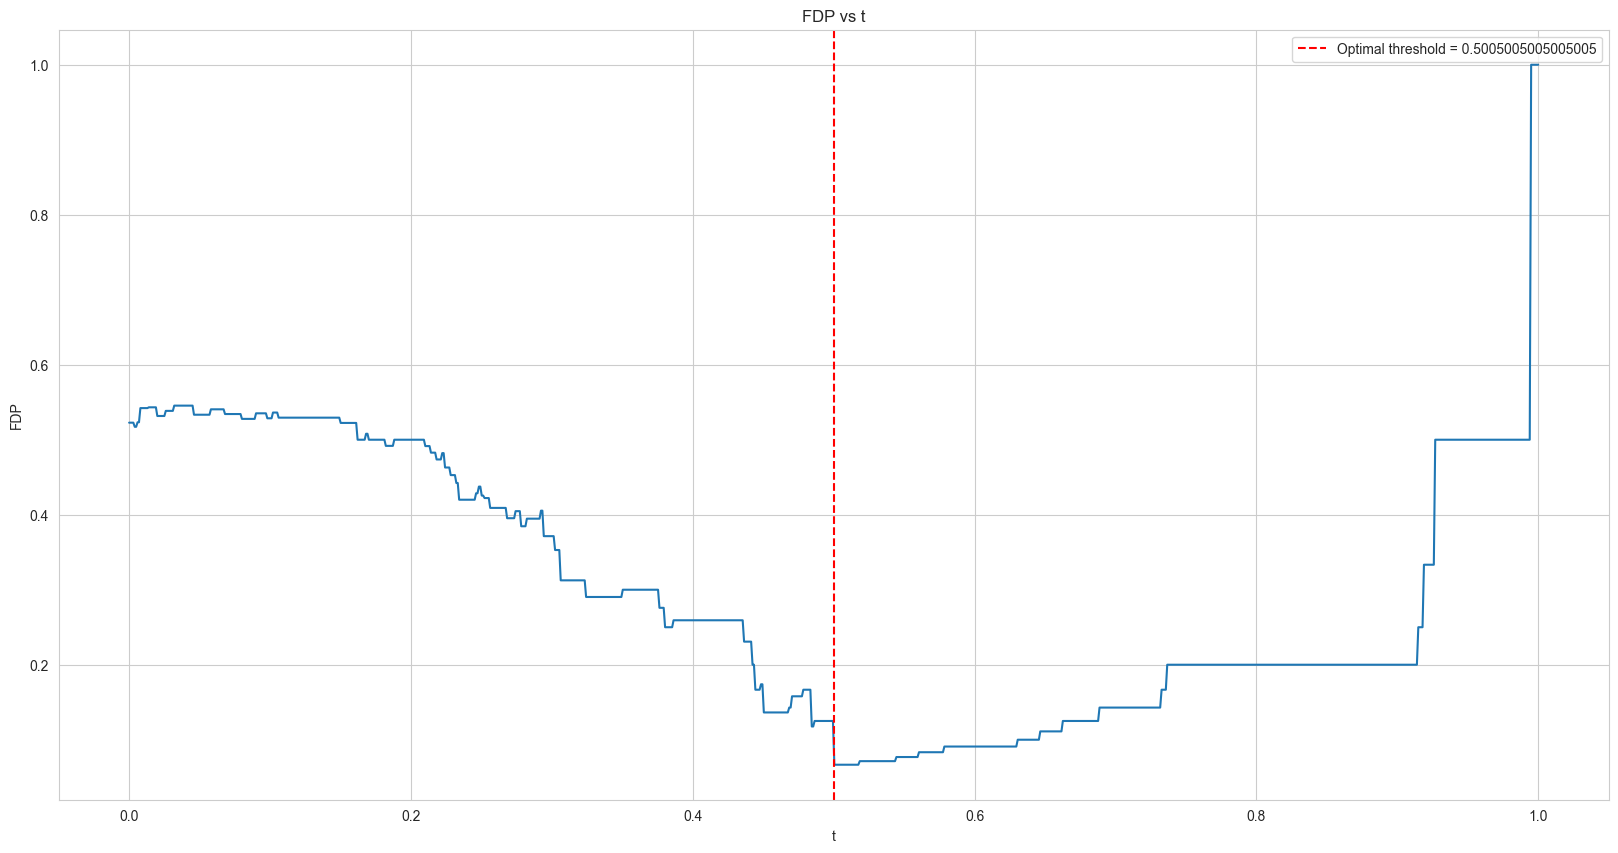

In [56]:
plt.figure(figsize=(20,10))
thr_opt = t[np.argmin(fdp)]
plt.plot(t, fdp)
plt.axvline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("t")
plt.ylabel("FDP")
plt.title("FDP vs t")
plt.legend()
plt.show()

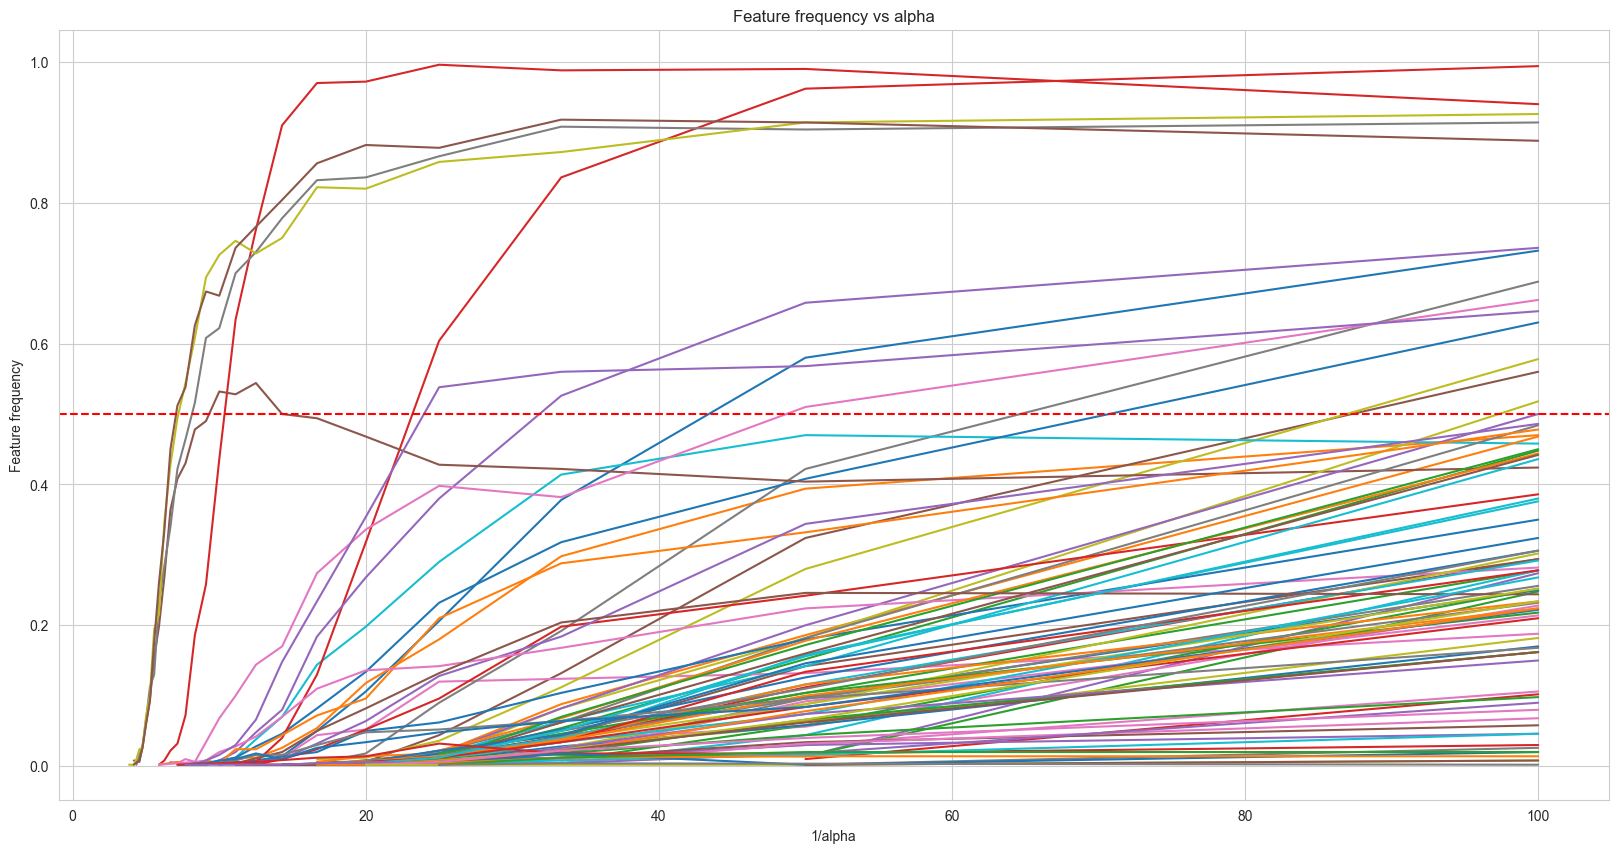

In [57]:
plt.figure(figsize=(20,10))
for feature in merged_feature_freq:
    alphas = merged_feature_freq[feature]["1/alpha"]
    freqs = merged_feature_freq[feature]["freq"]
    plt.plot(alphas, freqs, label=feature)
plt.xlabel("1/alpha")
plt.axhline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.ylabel("Feature frequency")
plt.title("Feature frequency vs alpha")
# plt.legend()
plt.show()

In [58]:
optimal_features = [feature for feature in merged_feature_freq if max(merged_feature_freq[feature]["freq"]) >= thr_opt]
print(optimal_features)
print(len(optimal_features))

['ens_charge', 'patch_pos', 'r_gyr', 'dipole_moment', 'hyd_moment', 'helicity', 'amphipathicity', 'BSA_LC_HC', 'DRT', 'hyd_idx', 'hyd_strength_cdr', 'Packing Score', 'patch_cdr_hyd', 'ASPmax', 'coeff_280']
15


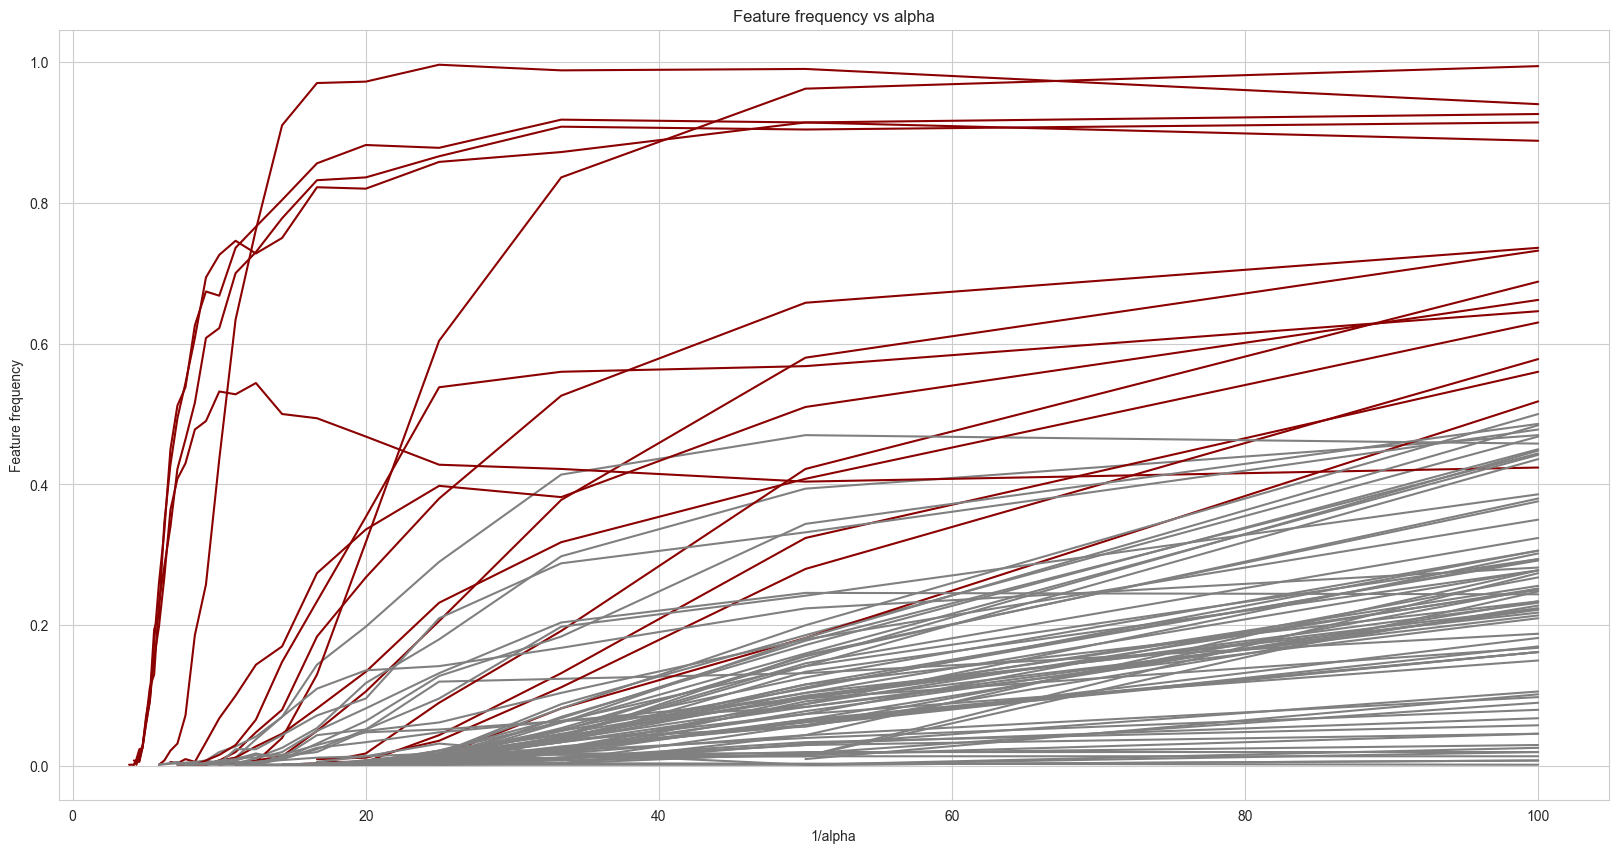

In [59]:
plt.figure(figsize=(20,10))
# colormap adapted
from matplotlib import colormaps
cmap = colormaps.get_cmap('tab20')
for i,feature in enumerate(merged_feature_freq):
    alphas = merged_feature_freq[feature]["1/alpha"]
    freqs = merged_feature_freq[feature]["freq"]
    if feature in optimal_features:
      plt.plot(alphas, freqs, color="darkred")
    else:
      plt.plot(alphas, freqs, color = "gray")
# plt.axhline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("1/alpha")
plt.ylabel("Feature frequency")
plt.title("Feature frequency vs alpha")
# plt.legend()
plt.show()

## Feature selection on CHO

In [60]:
alpha_params = list(np.linspace(0.01, 1, 100))
# n_bootstraps = 100
fraction = 1.0
target_property = "PR_CHO"
df_target_no_nan = df_target[target_property].dropna()
df_main_dataset = df_master_filtered
df_main_dataset = df_main_dataset.loc[df_target_no_nan.index]

variance_threshold = 0.
selector = VarianceThreshold(threshold=variance_threshold)
df_main_dataset_high_v = pd.DataFrame(selector.fit_transform(df_main_dataset), columns=selector.get_feature_names_out())
df_main_dataset_high_v.index = df_main_dataset.index
features_low_var = df_main_dataset.columns[~selector.get_support()]
print(f"Features with low variance: {features_low_var}")

df_data = (df_main_dataset_high_v - df_main_dataset_high_v.mean()) / df_main_dataset_high_v.std()
df_data[target_property] = df_target_no_nan
print(df_data.shape)
# n_bootstraps = df_data.shape[0]
n_bootstraps = 500
every_fdr = np.zeros(len(alpha_params))
every_feature_freq_cho = {}

Features with low variance: Index(['debye'], dtype='object')
(197, 46)


In [ ]:
for i in tqdm(range(len(alpha_params))):
  alpha = alpha_params[i]
  all_selected_features = train_stabl_proxy_one_alpha(df_data, target_property, n_bootstraps, alpha, fraction)
  feature_freq = compute_fdr_and_feature_freq(all_selected_features, n_bootstraps)
  every_feature_freq_cho[alpha] = feature_freq

100%|██████████| 100/100 [09:45<00:00,  5.85s/it]


In [ ]:
merged_feature_freq = merge_all_feature_freq(every_feature_freq_cho)
fdp, t = get_fdp_curve(merged_feature_freq)

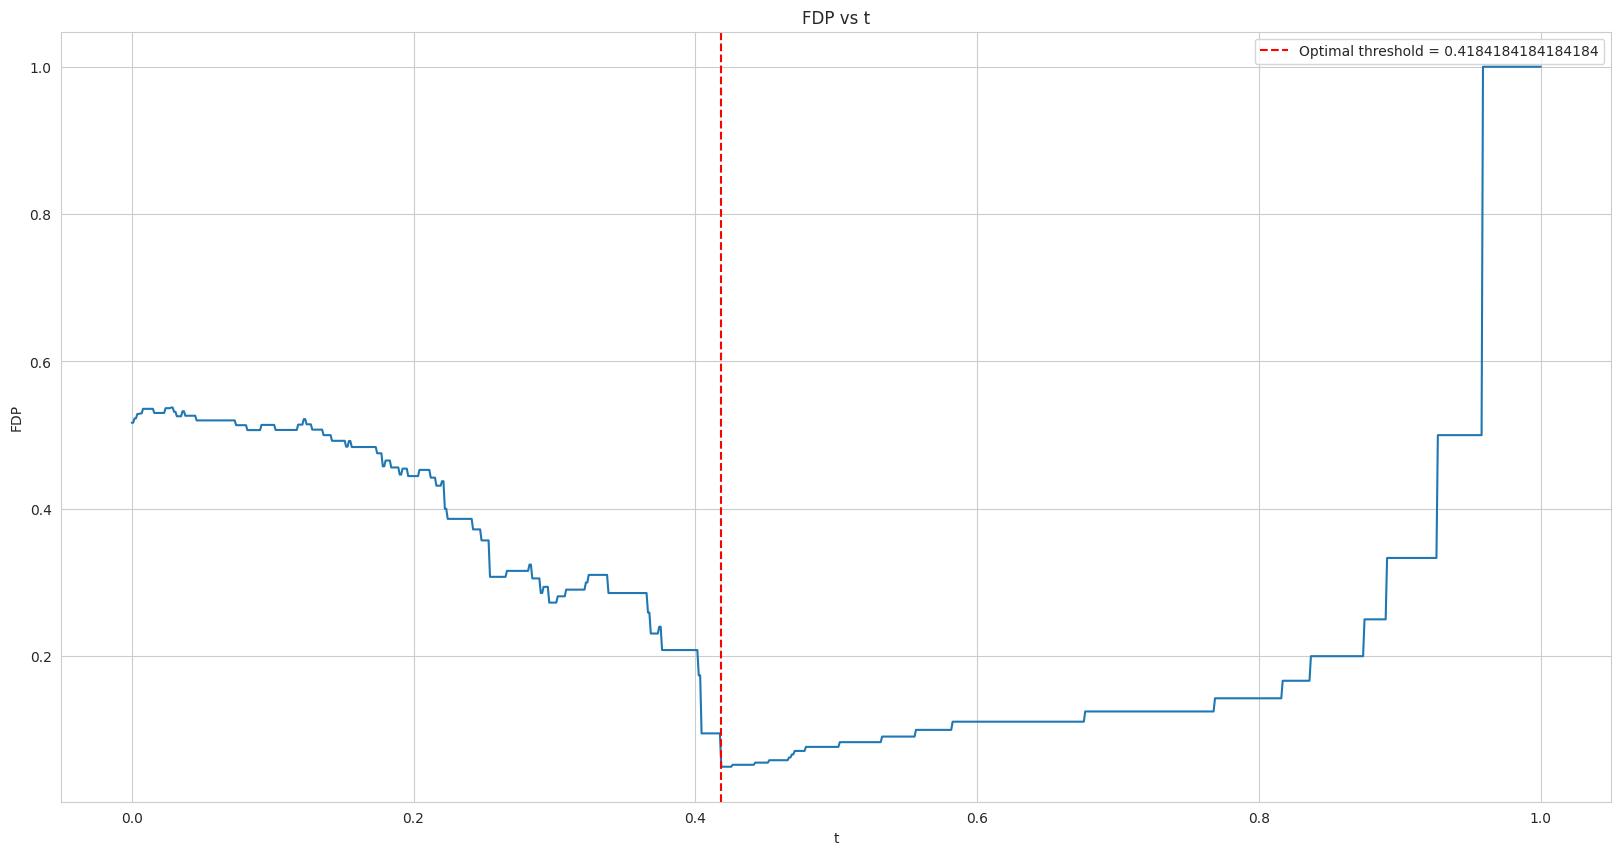

In [ ]:
plt.figure(figsize=(20,10))
thr_opt = t[np.argmin(fdp)]
plt.plot(t, fdp)
plt.axvline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("t")
plt.ylabel("FDP")
plt.title("FDP vs t")
plt.legend()
plt.show()

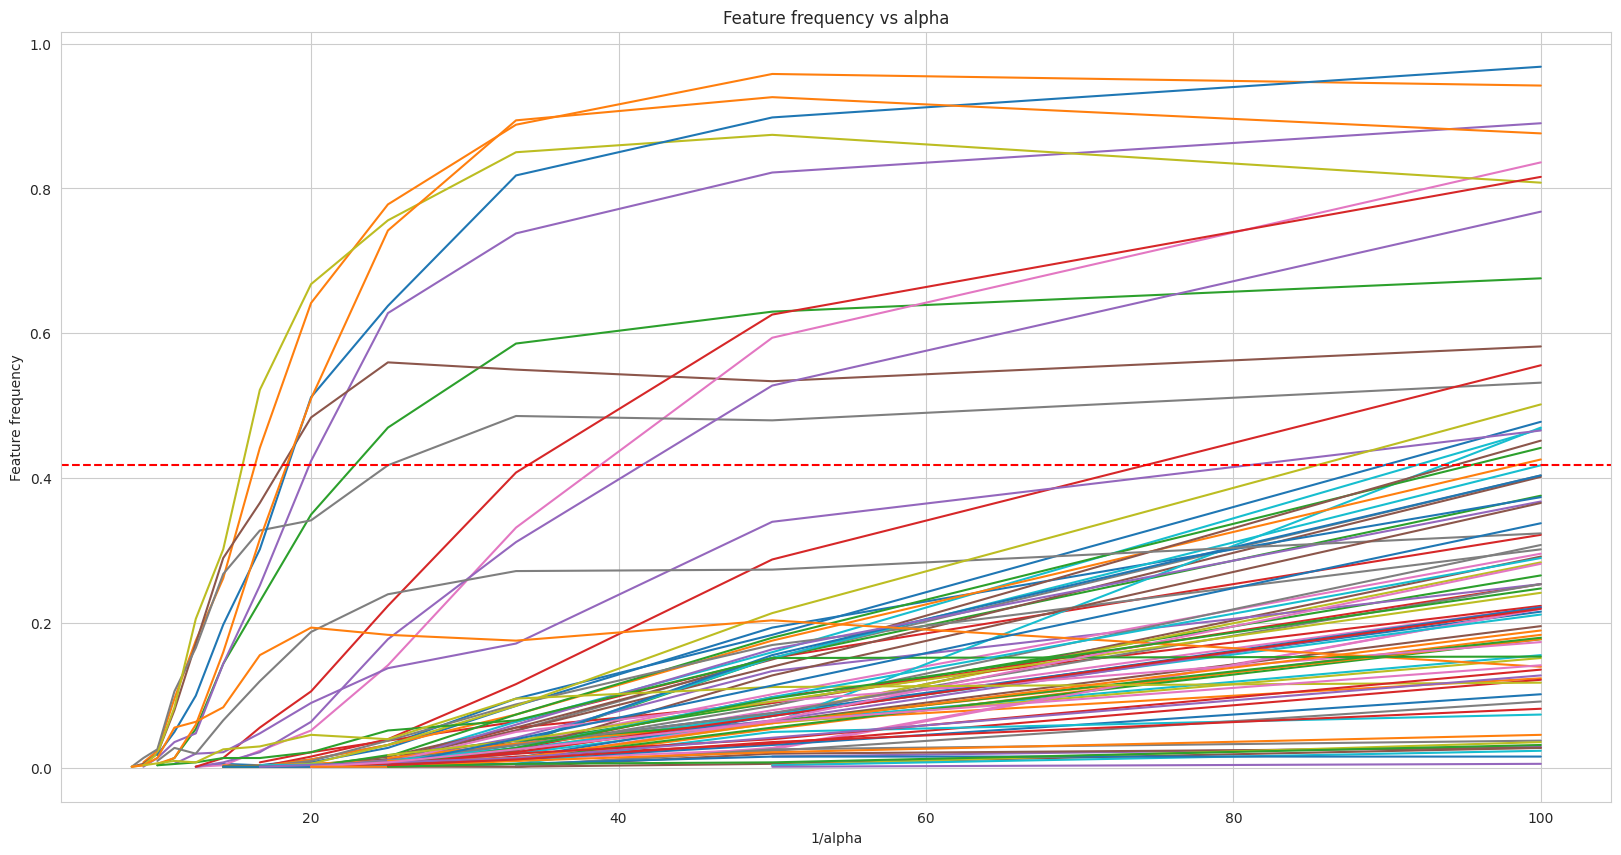

In [ ]:
plt.figure(figsize=(20,10))
for feature in merged_feature_freq:
    alphas = merged_feature_freq[feature]["1/alpha"]
    freqs = merged_feature_freq[feature]["freq"]
    plt.plot(alphas, freqs, label=feature)
plt.xlabel("1/alpha")
plt.axhline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.ylabel("Feature frequency")
plt.title("Feature frequency vs alpha")
# plt.legend()
plt.show()

In [ ]:
optimal_features = [feature for feature in merged_feature_freq if max(merged_feature_freq[feature]["freq"]) >= thr_opt]
print(optimal_features)
print(len(optimal_features))

['Fv_chml', 'patch_cdr_pos', 'patch_cdr_neg', 'asa_hyd', 'mobility', 'sed_const', 'zeta', 'zquadrupole', 'helicity', 'strand', 'E', 'HI', 'hyd_idx', 'patch_ion', 'dipole_moment', 'hyd_moment', 'coeff_280', 'zdipole', 'affinity_VL_VH', 'Packing Score']
20


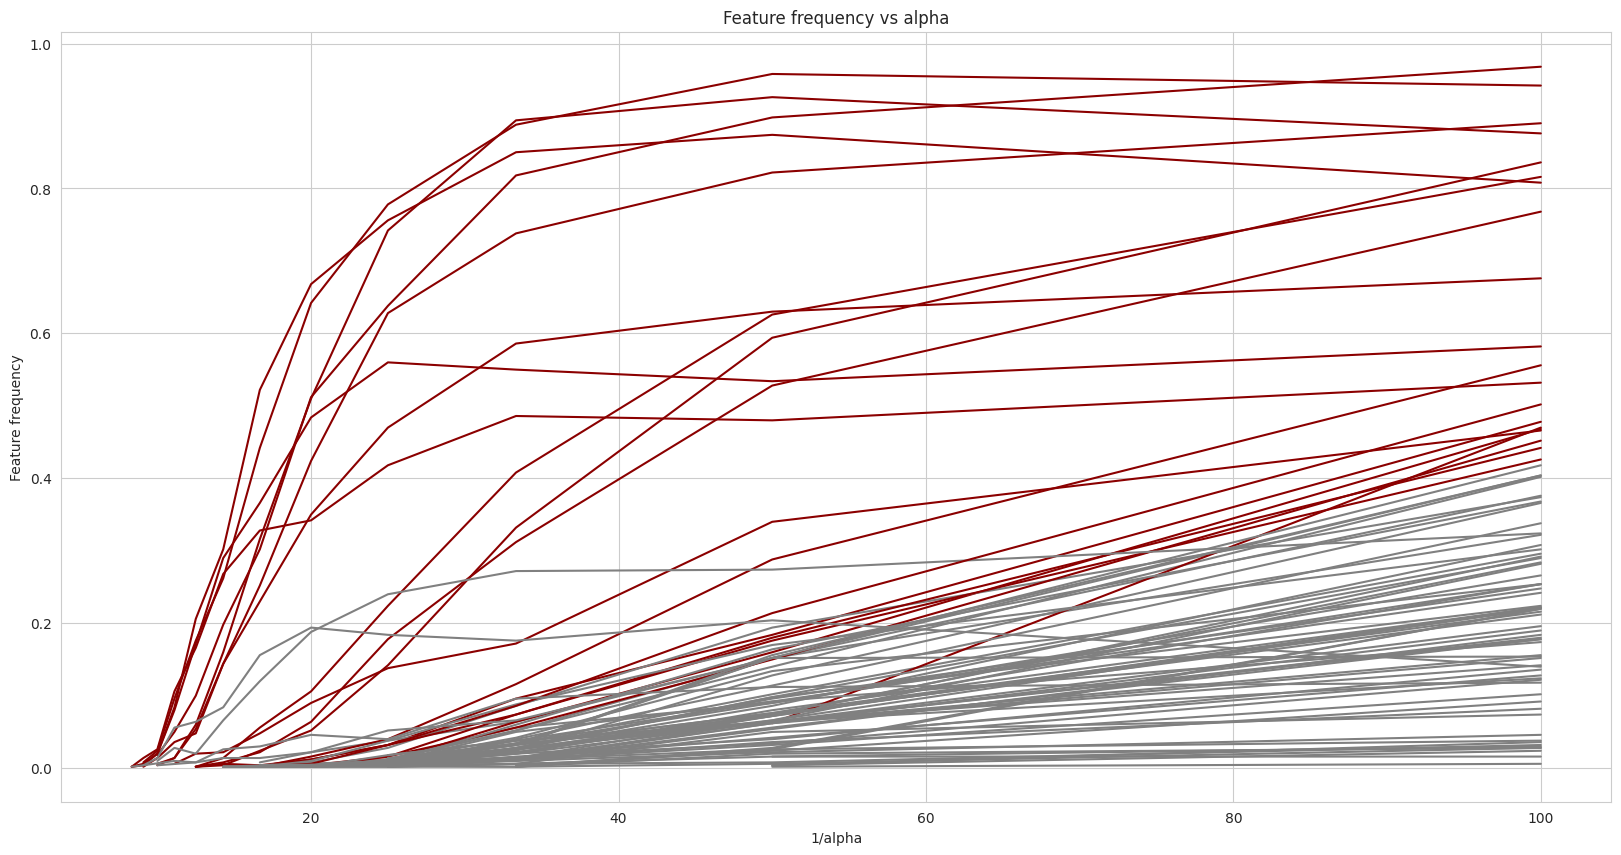

In [ ]:
plt.figure(figsize=(20,10))
# colormap adapted
from matplotlib import colormaps
cmap = colormaps.get_cmap('tab20')
for i,feature in enumerate(merged_feature_freq):
    alphas = merged_feature_freq[feature]["1/alpha"]
    freqs = merged_feature_freq[feature]["freq"]
    if feature in optimal_features:
      plt.plot(alphas, freqs, label=feature, color="darkred")
    else:
      plt.plot(alphas, freqs, label=feature, color = "gray")
# plt.axhline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("1/alpha")
plt.ylabel("Feature frequency")
plt.title("Feature frequency vs alpha")
# plt.legend()
plt.show()

## Feature selection on AC-SINS

In [61]:
alpha_params = list(np.linspace(0.01, 1, 100))
# n_bootstraps = 100
fraction = 1.0
target_property = "AC-SINS_pH7.4"
df_target_no_nan = df_target[target_property].dropna()
df_main_dataset = df_master_filtered
df_main_dataset = df_main_dataset.loc[df_target_no_nan.index]

variance_threshold = 0.
selector = VarianceThreshold(threshold=variance_threshold)
df_main_dataset_high_v = pd.DataFrame(selector.fit_transform(df_main_dataset), columns=selector.get_feature_names_out())
df_main_dataset_high_v.index = df_main_dataset.index
features_low_var = df_main_dataset.columns[~selector.get_support()]
print(f"Features with low variance: {features_low_var}")

df_data = (df_main_dataset_high_v - df_main_dataset_high_v.mean()) / df_main_dataset_high_v.std()
df_data[target_property] = df_target_no_nan
print(df_data.shape)
# n_bootstraps = df_data.shape[0]
n_bootstraps = 500
every_fdr = np.zeros(len(alpha_params))
every_feature_freq_acs = {}
max_iter = 2000

Features with low variance: Index(['debye'], dtype='object')
(242, 46)


In [ ]:
for i in tqdm(range(len(alpha_params))):
  alpha = alpha_params[i]
  all_selected_features = train_stabl_proxy_one_alpha(df_data, target_property, n_bootstraps, alpha, fraction, max_iter = max_iter)
  feature_freq = compute_fdr_and_feature_freq(all_selected_features, n_bootstraps)
  every_feature_freq_acs[alpha] = feature_freq

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.919e+01, tolerance: 1.394e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.923e+00, tolerance: 1.623e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

In [ ]:
merged_feature_freq = merge_all_feature_freq(every_feature_freq_acs)
fdp, t = get_fdp_curve(merged_feature_freq)

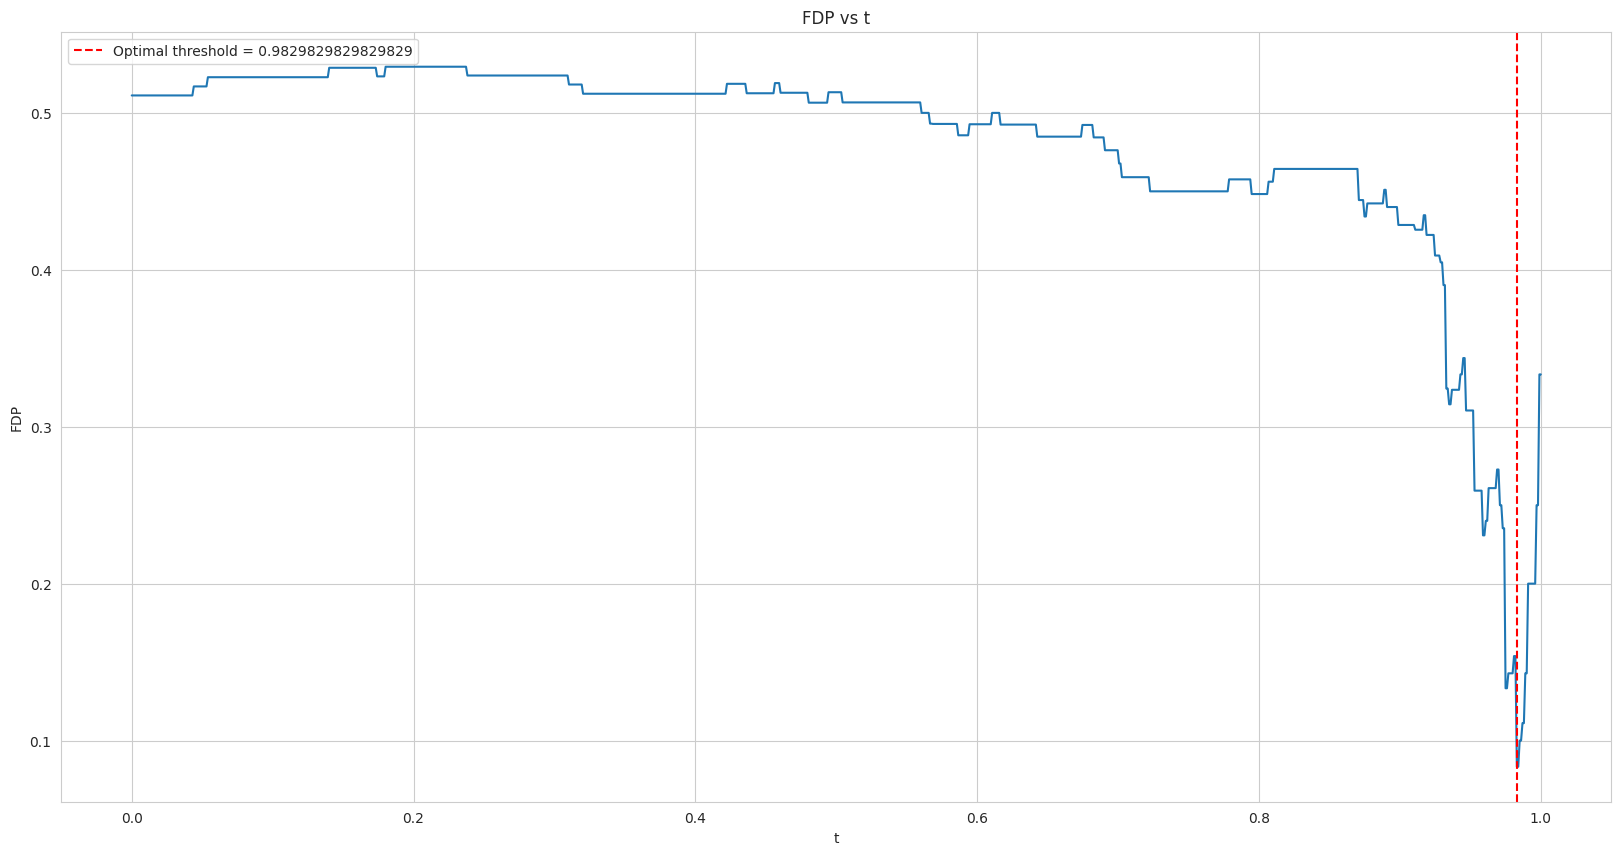

In [ ]:
plt.figure(figsize=(20,10))
thr_opt = t[np.argmin(fdp)]
plt.plot(t, fdp)
plt.axvline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("t")
plt.ylabel("FDP")
plt.title("FDP vs t")
plt.legend()
plt.show()

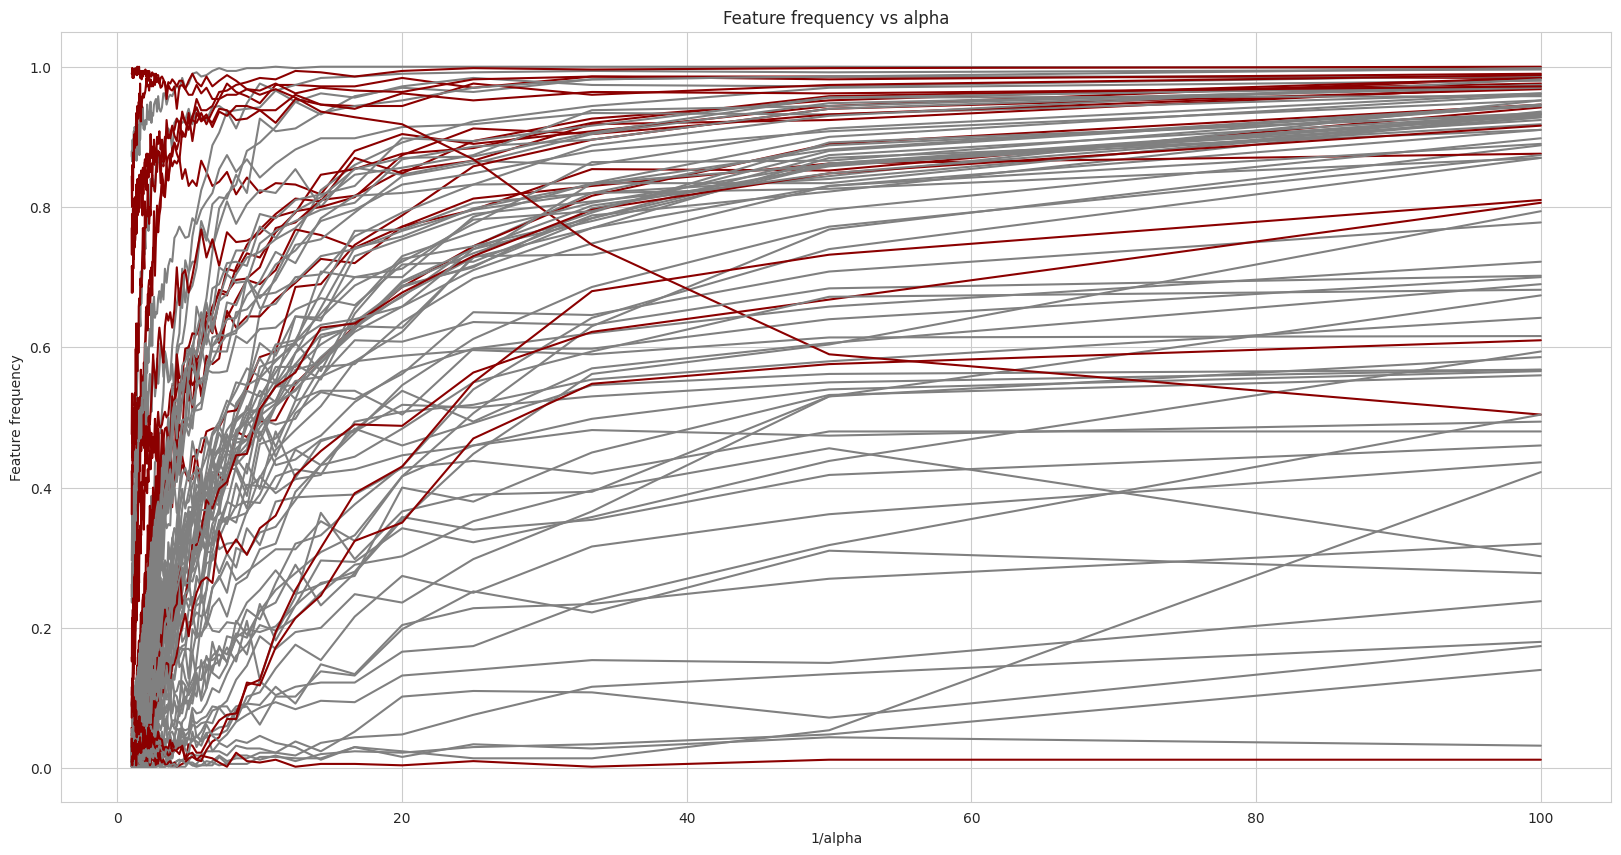

In [ ]:
plt.figure(figsize=(20,10))
# colormap adapted
from matplotlib import colormaps
cmap = colormaps.get_cmap('tab20')
for i,feature in enumerate(merged_feature_freq):
    alphas = merged_feature_freq[feature]["1/alpha"]
    freqs = merged_feature_freq[feature]["freq"]
    if feature in optimal_features:
      plt.plot(alphas, freqs, label=feature, color="darkred")
    else:
      plt.plot(alphas, freqs, label=feature, color = "gray")
# plt.axhline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("1/alpha")
plt.ylabel("Feature frequency")
plt.title("Feature frequency vs alpha")
# plt.legend()
plt.show()

In [ ]:
optimal_features = [feature for feature in merged_feature_freq if max(merged_feature_freq[feature]["freq"]) >= thr_opt]
print(optimal_features)
print(len(optimal_features))

['ens_charge', 'Fv_chml', 'patch_cdr_neg', 'patch_pos', 'patch_neg', 'r_gyr', 'dipole_moment', 'coeff_280', 'zquadrupole', 'helicity', 'amphipathicity', 'sed_const']
12


## Feature selection on Titer

In [62]:
alpha_params = list(np.linspace(0.01, 1, 100))
# n_bootstraps = 100
fraction = 1.0
target_property = "Titer"
df_target_no_nan = df_target[target_property].dropna()
df_main_dataset = df_master_filtered
df_main_dataset = df_main_dataset.loc[df_target_no_nan.index]

variance_threshold = 0.
selector = VarianceThreshold(threshold=variance_threshold)
df_main_dataset_high_v = pd.DataFrame(selector.fit_transform(df_main_dataset), columns=selector.get_feature_names_out())
df_main_dataset_high_v.index = df_main_dataset.index
features_low_var = df_main_dataset.columns[~selector.get_support()]
print(f"Features with low variance: {features_low_var}")

df_data = (df_main_dataset_high_v - df_main_dataset_high_v.mean()) / df_main_dataset_high_v.std()
df_data[target_property] = df_target_no_nan
print(df_data.shape)
# n_bootstraps = df_data.shape[0]
n_bootstraps = 500
every_fdr = np.zeros(len(alpha_params))
every_feature_freq_titer = {}
max_iter = 3000

Features with low variance: Index(['debye'], dtype='object')
(239, 46)


In [ ]:
for i in tqdm(range(len(alpha_params))):
  alpha = alpha_params[i]
  all_selected_features = train_stabl_proxy_one_alpha(df_data, target_property, n_bootstraps, alpha, fraction, max_iter = max_iter)
  feature_freq = compute_fdr_and_feature_freq(all_selected_features, n_bootstraps)
  every_feature_freq_titer[alpha] = feature_freq

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e+02, tolerance: 1.424e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e+02, tolerance: 1.494e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

In [ ]:
merged_feature_freq = merge_all_feature_freq(every_feature_freq_titer)
fdp, t = get_fdp_curve(merged_feature_freq)

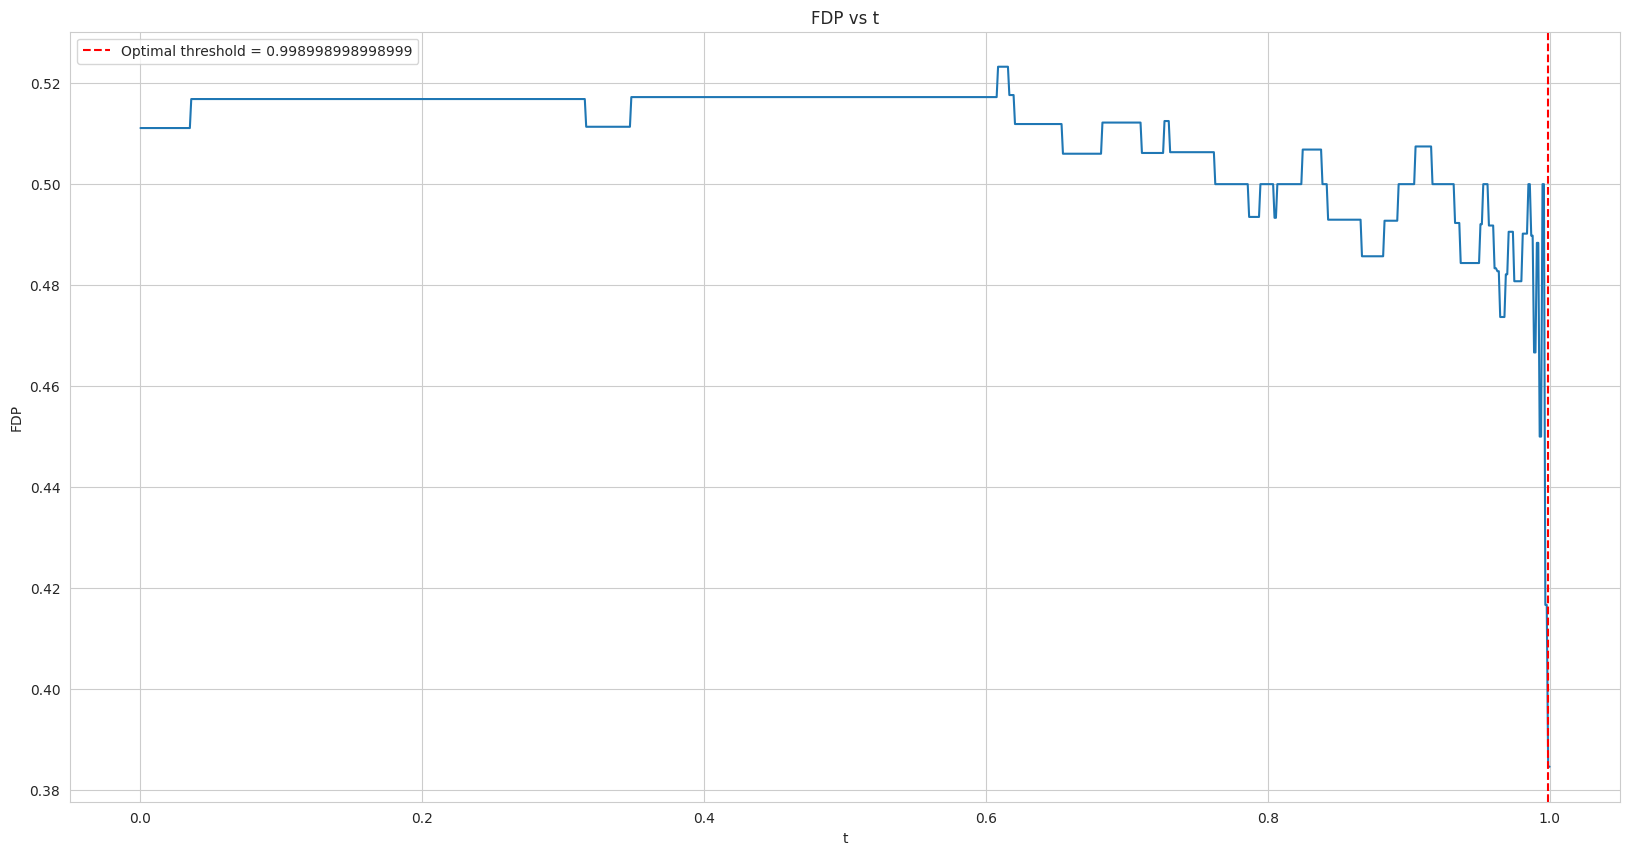

In [ ]:
plt.figure(figsize=(20,10))
thr_opt = t[np.argmin(fdp)]
plt.plot(t, fdp)
plt.axvline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("t")
plt.ylabel("FDP")
plt.title("FDP vs t")
plt.legend()
plt.show()

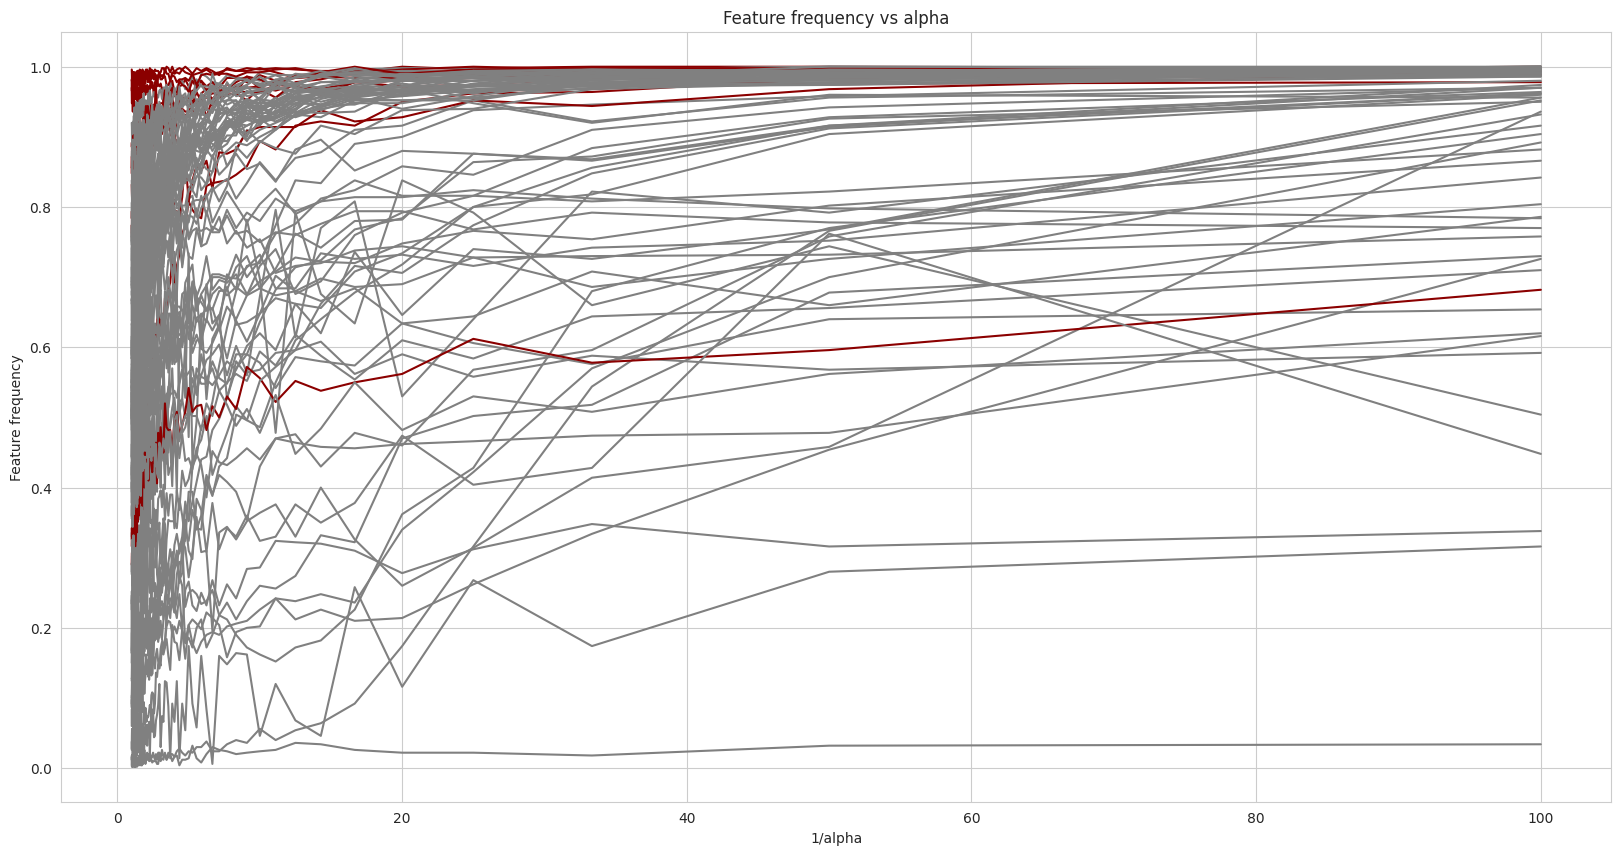

In [ ]:
plt.figure(figsize=(20,10))
# colormap adapted
from matplotlib import colormaps
cmap = colormaps.get_cmap('tab20')
for i,feature in enumerate(merged_feature_freq):
    alphas = merged_feature_freq[feature]["1/alpha"]
    freqs = merged_feature_freq[feature]["freq"]
    if feature in optimal_features:
      plt.plot(alphas, freqs, label=feature, color="darkred")
    else:
      plt.plot(alphas, freqs, label=feature, color = "gray")
# plt.axhline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("1/alpha")
plt.ylabel("Feature frequency")
plt.title("Feature frequency vs alpha")
# plt.legend()
plt.show()

In [ ]:
optimal_features = [feature for feature in merged_feature_freq if max(merged_feature_freq[feature]["freq"]) >= thr_opt]
print(optimal_features)
print(len(optimal_features))

['patch_pos', 'r_gyr', 'dipole_moment', 'hyd_moment', 'helicity', 'E', 'amphipathicity', 'hyd_strength', 'Packing Score', 'strand_artificial', 'dipole_moment_artificial', 'Packing Score_artificial', 'helicity_artificial']
13


## Feature selection on theromostability

In [63]:
alpha_params = list(np.linspace(0.01, 1, 100))
# n_bootstraps = 100
fraction = 1.0
target_property = "Tm2"
df_target_no_nan = df_target[target_property].dropna()
df_main_dataset = df_master_filtered
df_main_dataset = df_main_dataset.loc[df_target_no_nan.index]

variance_threshold = 0.
selector = VarianceThreshold(threshold=variance_threshold)
df_main_dataset_high_v = pd.DataFrame(selector.fit_transform(df_main_dataset), columns=selector.get_feature_names_out())
df_main_dataset_high_v.index = df_main_dataset.index
features_low_var = df_main_dataset.columns[~selector.get_support()]
print(f"Features with low variance: {features_low_var}")

df_data = (df_main_dataset_high_v - df_main_dataset_high_v.mean()) / df_main_dataset_high_v.std()
df_data[target_property] = df_target_no_nan
# n_bootstraps = df_data.shape[0]
print(df_data.shape)
n_bootstraps = 500
every_fdr = np.zeros(len(alpha_params))
every_feature_freq_tm = {}
max_iter = 2000

Features with low variance: Index(['debye'], dtype='object')
(193, 46)


In [ ]:
for i in tqdm(range(len(alpha_params))):
  alpha = alpha_params[i]
  all_selected_features = train_stabl_proxy_one_alpha(df_data, target_property, n_bootstraps, alpha, fraction, max_iter = max_iter)
  feature_freq = compute_fdr_and_feature_freq(all_selected_features, n_bootstraps)
  every_feature_freq_tm[alpha] = feature_freq

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.810e+00, tolerance: 2.224e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+00, tolerance: 1.777e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

In [ ]:
merged_feature_freq = merge_all_feature_freq(every_feature_freq_tm)
fdp, t = get_fdp_curve(merged_feature_freq)

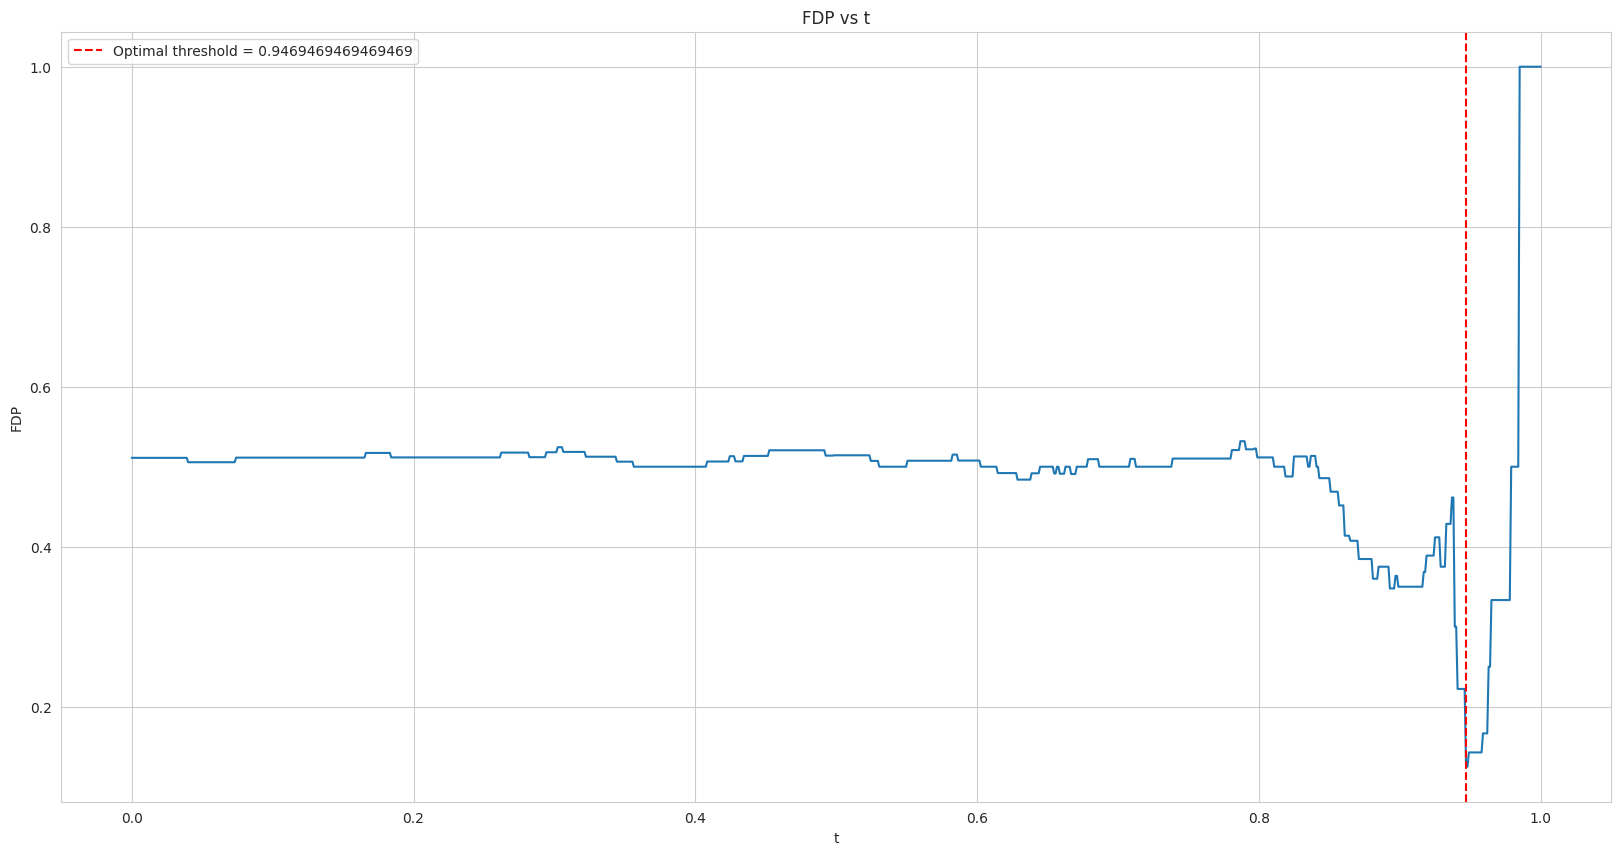

In [ ]:
plt.figure(figsize=(20,10))
thr_opt = t[np.argmin(fdp)]
plt.plot(t, fdp)
plt.axvline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("t")
plt.ylabel("FDP")
plt.title("FDP vs t")
plt.legend()
plt.show()

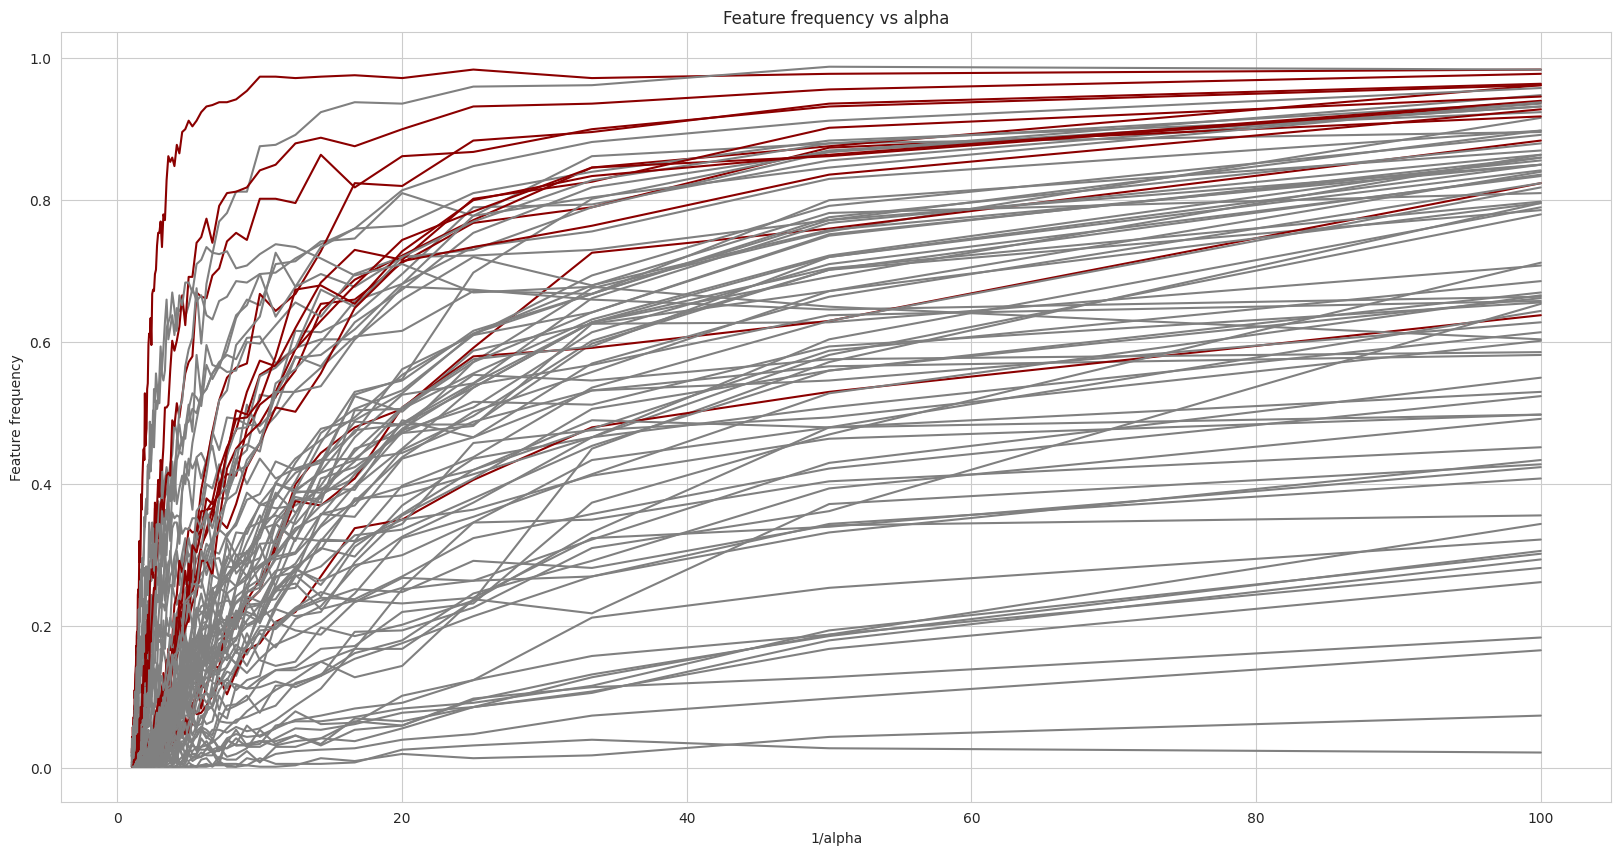

In [ ]:
plt.figure(figsize=(20,10))
# colormap adapted
from matplotlib import colormaps
cmap = colormaps.get_cmap('tab20')
for i,feature in enumerate(merged_feature_freq):
    alphas = merged_feature_freq[feature]["1/alpha"]
    freqs = merged_feature_freq[feature]["freq"]
    if feature in optimal_features:
      plt.plot(alphas, freqs, label=feature, color="darkred")
    else:
      plt.plot(alphas, freqs, label=feature, color = "gray")
# plt.axhline(thr_opt, color='r', linestyle='--', label = "Optimal threshold = "+str(thr_opt))
plt.xlabel("1/alpha")
plt.ylabel("Feature frequency")
plt.title("Feature frequency vs alpha")
# plt.legend()
plt.show()

In [ ]:
optimal_features = [feature for feature in merged_feature_freq if max(merged_feature_freq[feature]["freq"]) >= thr_opt]
print(optimal_features)
print(len(optimal_features))

['hyd_moment', 'zquadrupole', 'helicity', 'strand', 'E', 'amphipathicity', 'hyd_idx_cdr', 'Packing Score']
8


# Conclusions

> * Dimensionality reduction shows that HIC's variations seems to nicely correlate with data point position in the 2D PCA plane.
> * Correlation analysis show that some MD features are highly correlated with the outcomes. Dataset seems to have a hierarchical structure where some targets will correlate with others (ex: HIC with Tm2 or CHO with Titer)
> * We have applied the methodology described in *Stabl: sparse and reliable biomarker discovery in predictive modeling of high-dimensional omic data, Jean Hédou et al. 2024, Nature Biotechnology* to produce subsets of reliable MD features that are likely to play an important role in further feature engineering, model selection or model performance. This set of features is not selected from the model performance on the 5-fold split given for this competition but on a multitude of bootstraps with data-driven hyperparameter tuning.